<a href="https://colab.research.google.com/github/Tamaghnatech/Claims_Severity_Allstate/blob/main/AllState_Claims_Severity_Check_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Separate the target variable
y_train = train['loss']
train = train.drop(columns=['loss'])

# Identify numeric columns
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns
categorical_features = train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Now fit and transform the train data and only transform the test data
train_preprocessed = preprocessor.fit_transform(train)
test_preprocessed = preprocessor.transform(test)


In [9]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_preprocessed, label=y_train)

params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    # Add other parameters here based on your tuning
}

bst = xgb.train(params, dtrain, num_boost_round=1000)  # num_boost_round might need tuning


In [11]:
batch_size = 16  # Reduced from 32
epochs = 20     # Reduced from 50


In [12]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
X_train_dense = X_train.todense()
X_val_dense = X_val.todense()


In [15]:
model.fit(X_train_dense, y_train_split,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_val_dense, y_val_split),
          callbacks=[early_stop])


Epoch 1/20
9416/9416 [==============================] - 20s 2ms/step - loss: 1325.5222 - val_loss: 1200.3585
Epoch 2/20
9416/9416 [==============================] - 19s 2ms/step - loss: 1199.0609 - val_loss: 1182.7089
Epoch 3/20
9416/9416 [==============================] - 19s 2ms/step - loss: 1187.0142 - val_loss: 1173.0660
Epoch 4/20
9416/9416 [==============================] - 19s 2ms/step - loss: 1176.7567 - val_loss: 1173.3256
Epoch 5/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1168.2799 - val_loss: 1161.0490
Epoch 6/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1161.7837 - val_loss: 1168.9944
Epoch 7/20
9416/9416 [==============================] - 19s 2ms/step - loss: 1156.7285 - val_loss: 1155.2706
Epoch 8/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1152.9137 - val_loss: 1153.9368
Epoch 9/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1149.4132 - val_loss: 1156.6450
Epoch 10/20
9416/94

In [16]:
val_loss = model.evaluate(X_val_dense, y_val_split)
print(f"Validation Mean Absolute Error: {val_loss}")


1177/1177 [==============================] - 1s 1ms/step - loss: 1147.7400
Validation Mean Absolute Error: 1147.739990234375


In [22]:
test_predictions = model.predict(test_preprocessed.todense())


3924/3924 [==============================] - 4s 990us/step


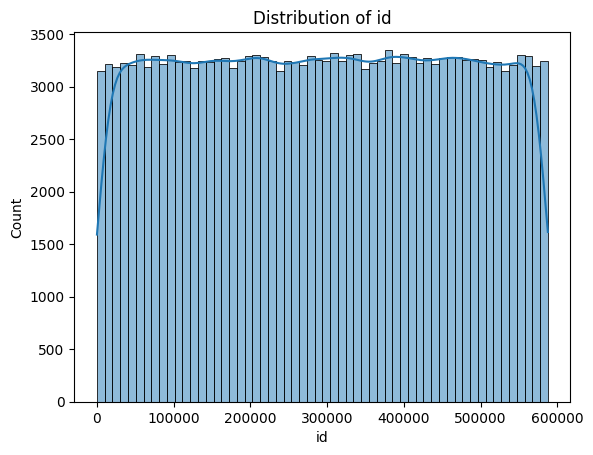

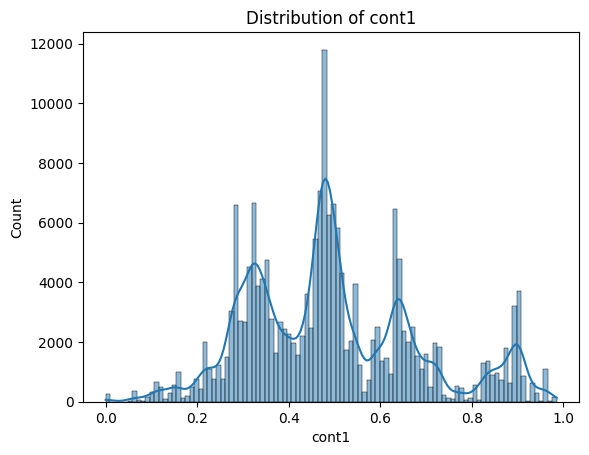

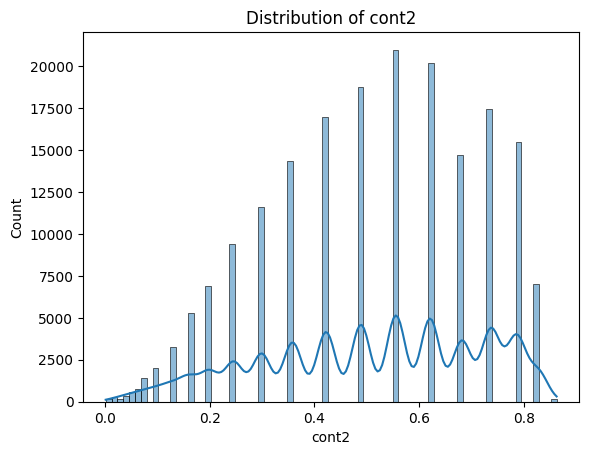

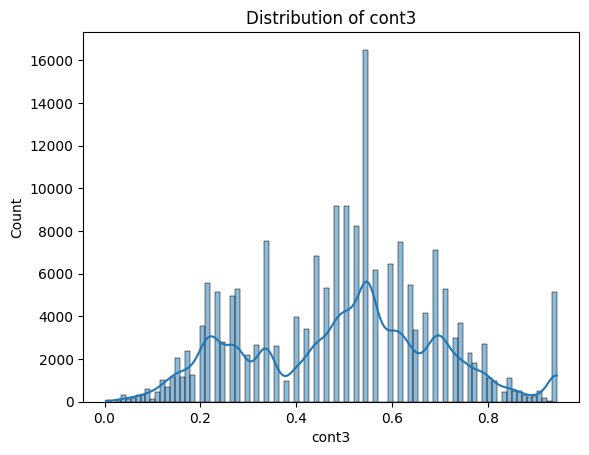

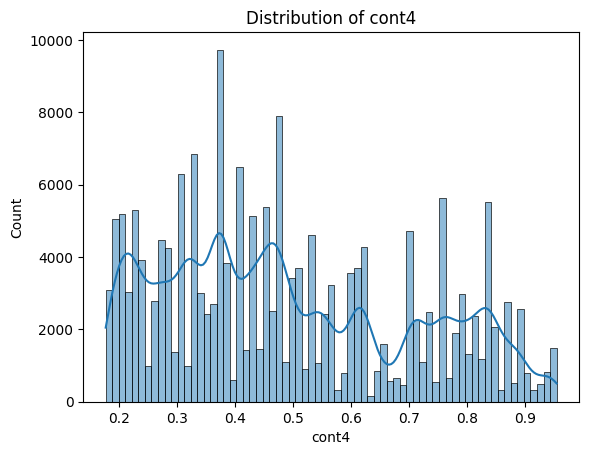

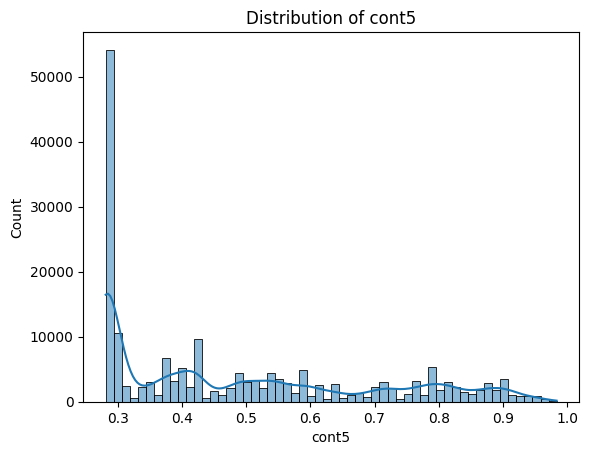

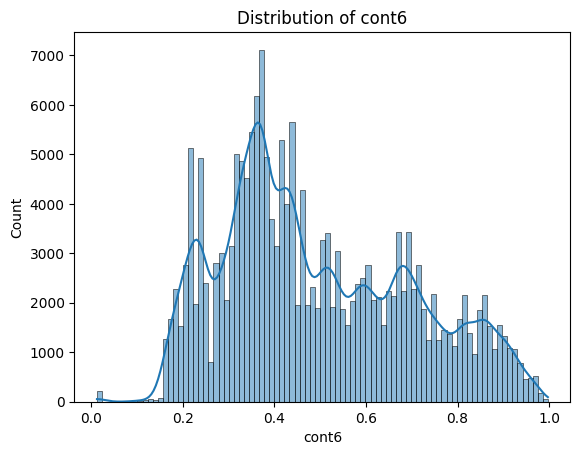

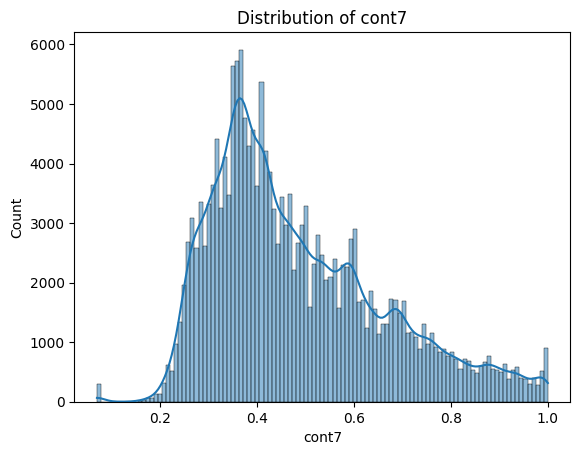

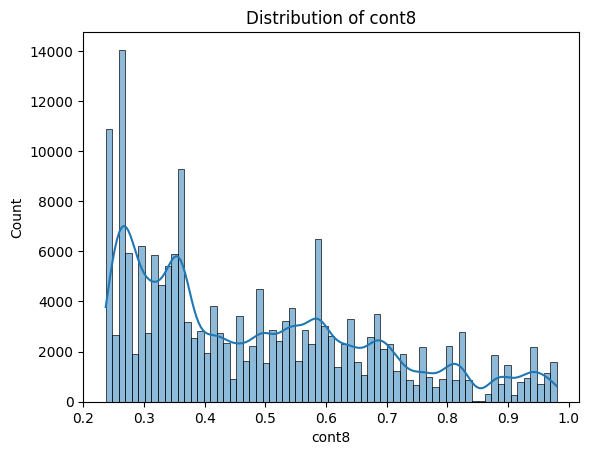

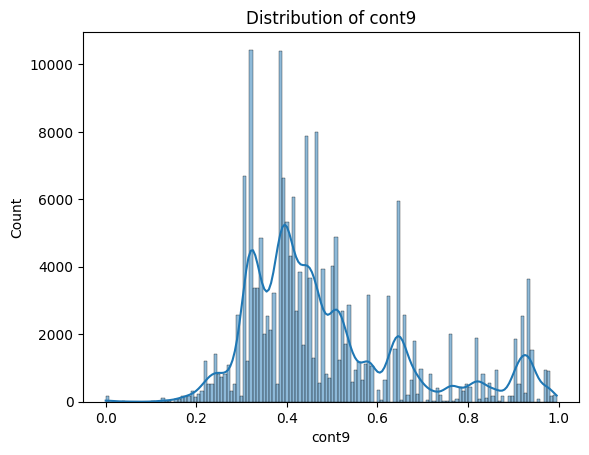

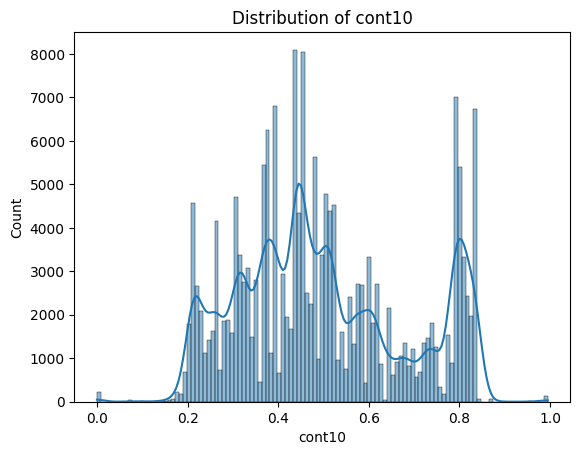

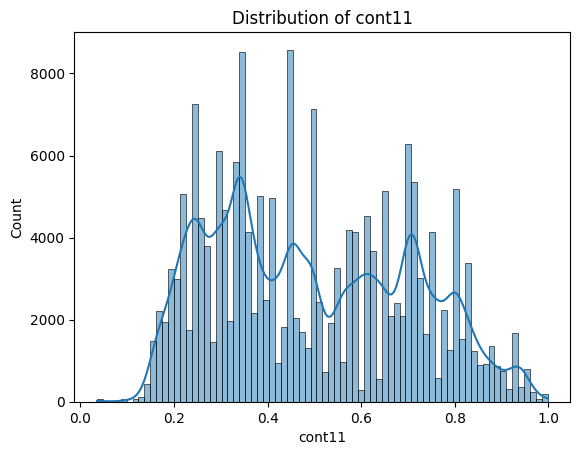

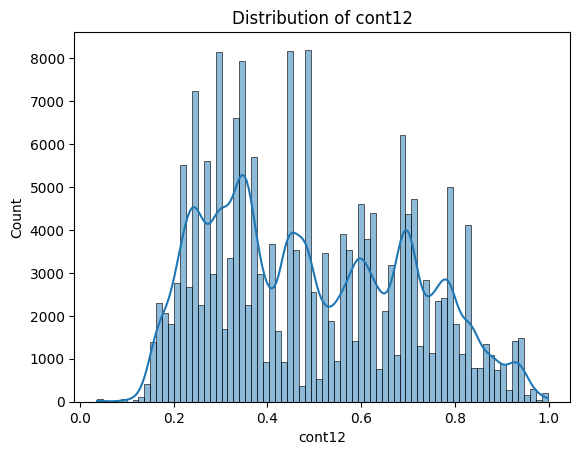

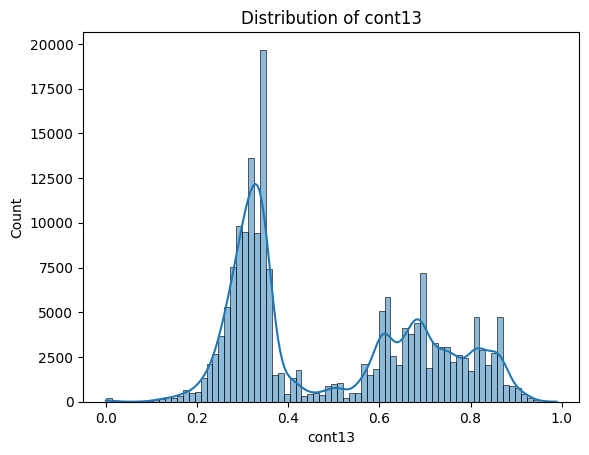

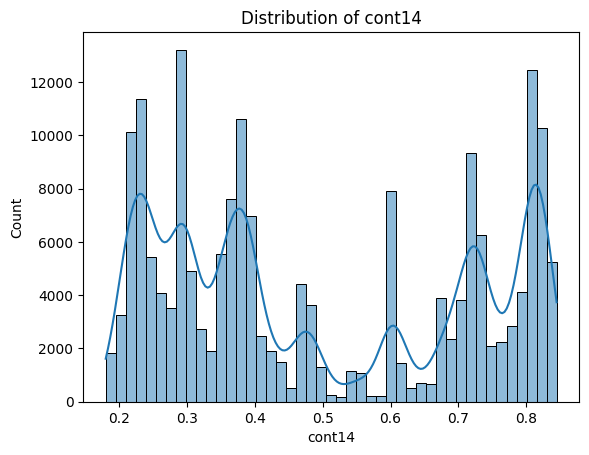

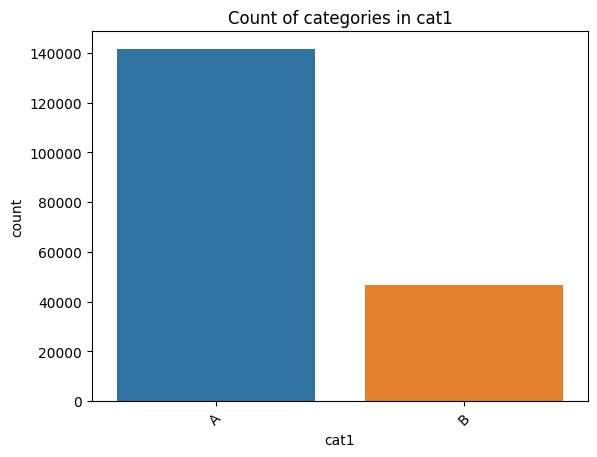

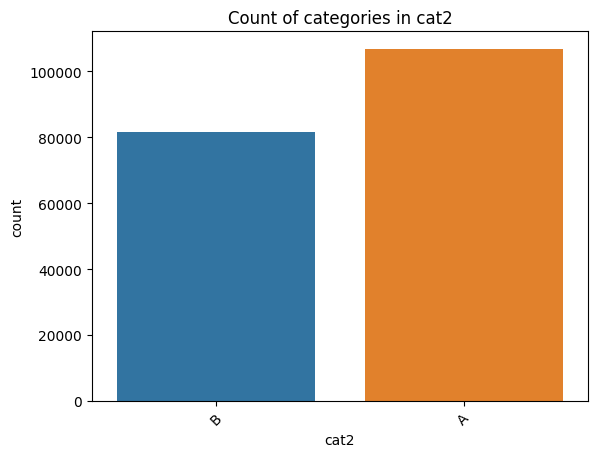

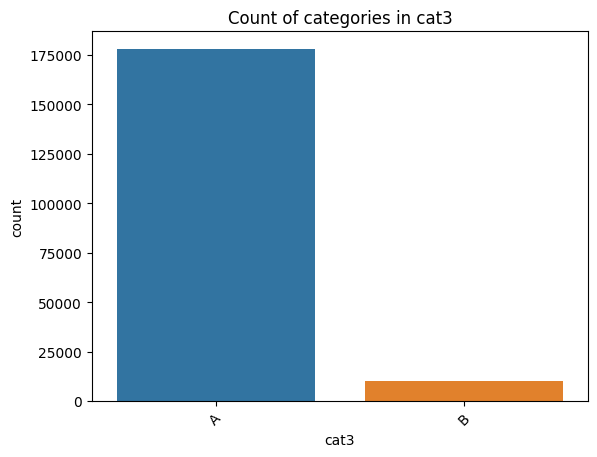

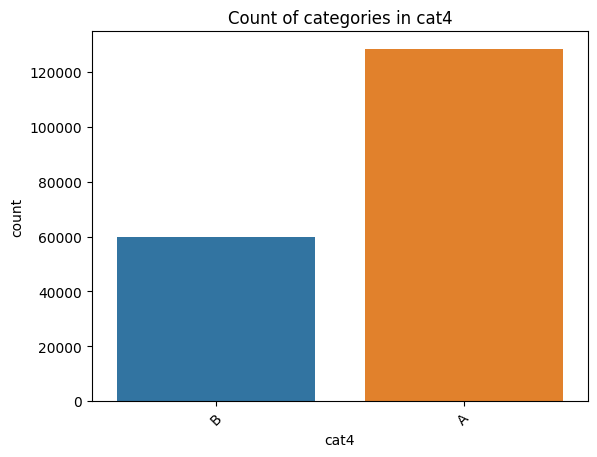

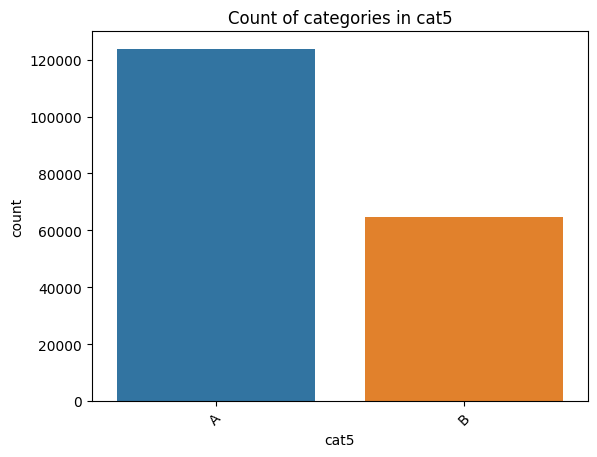

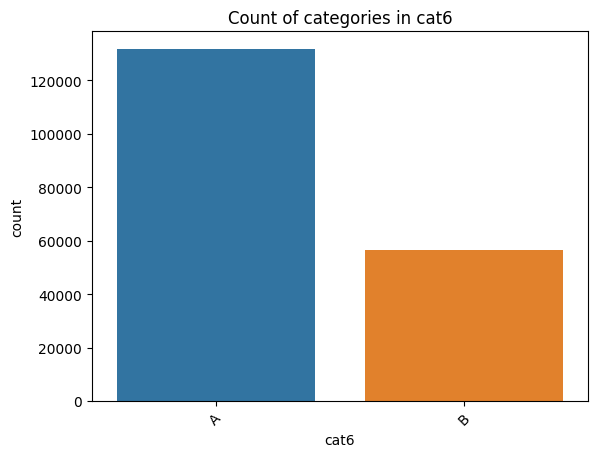

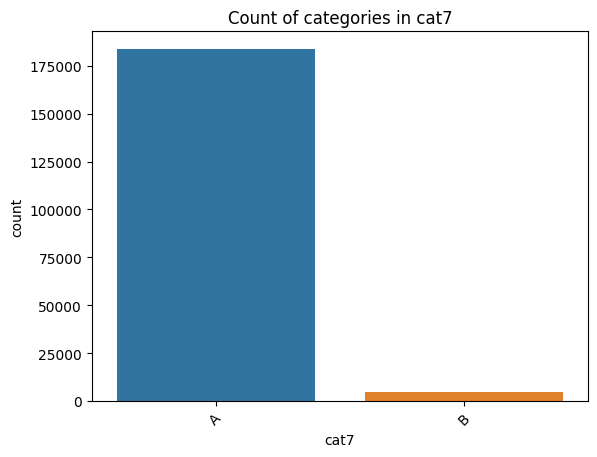

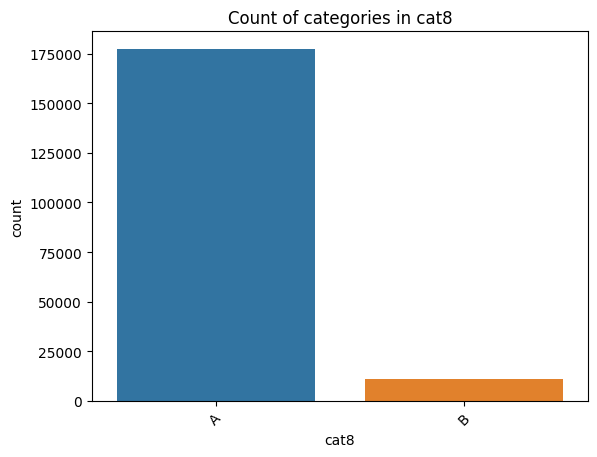

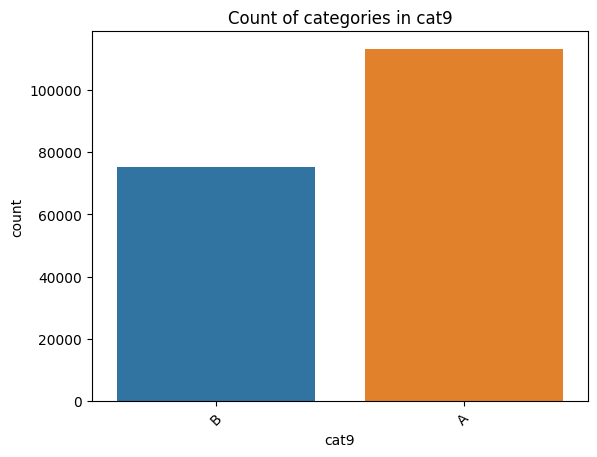

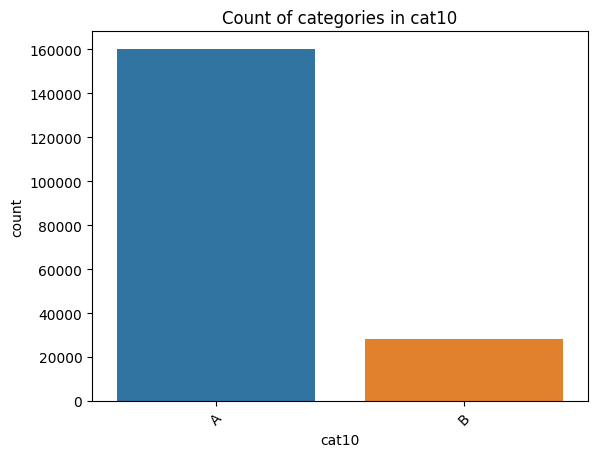

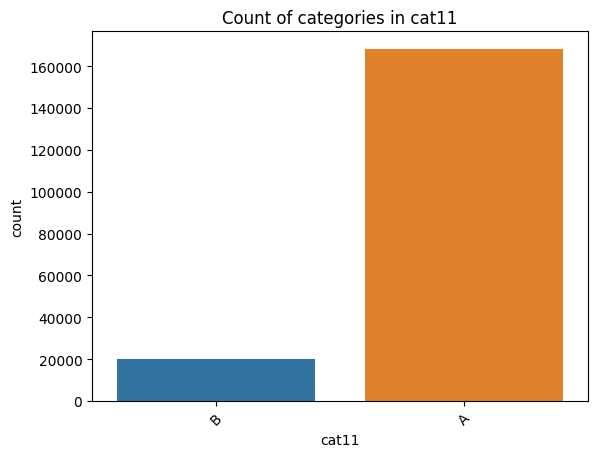

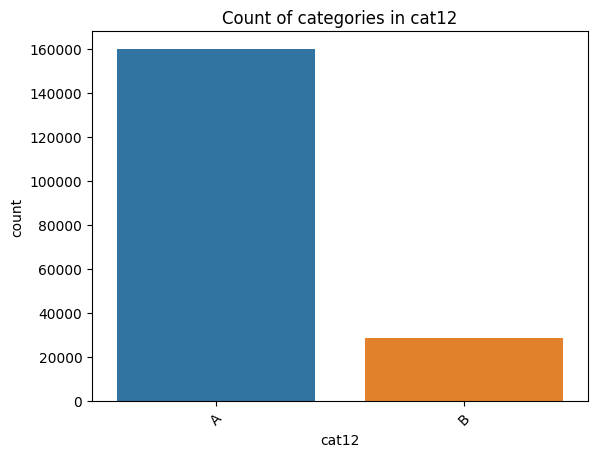

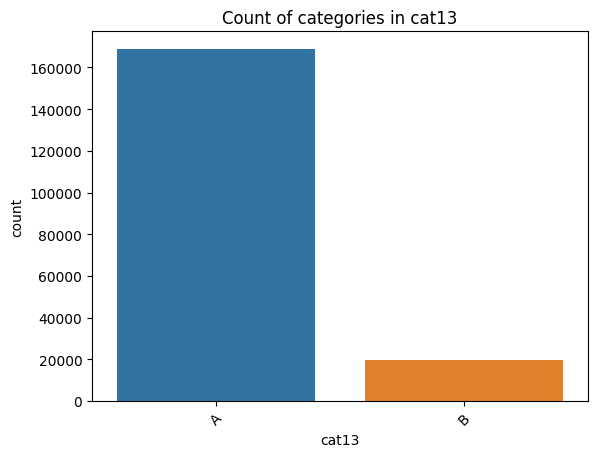

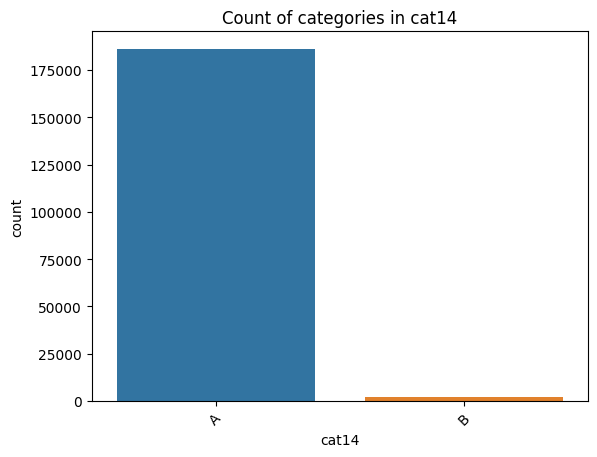

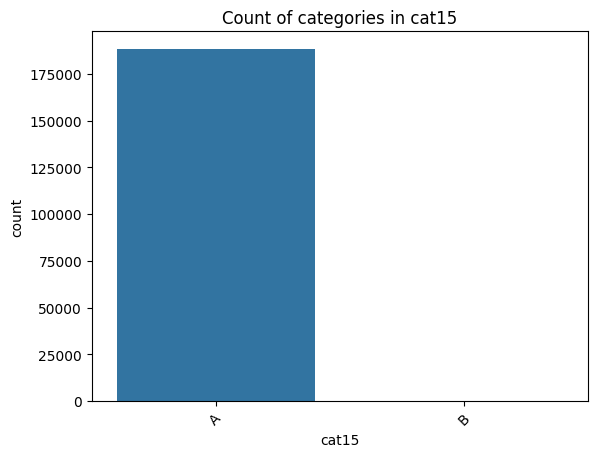

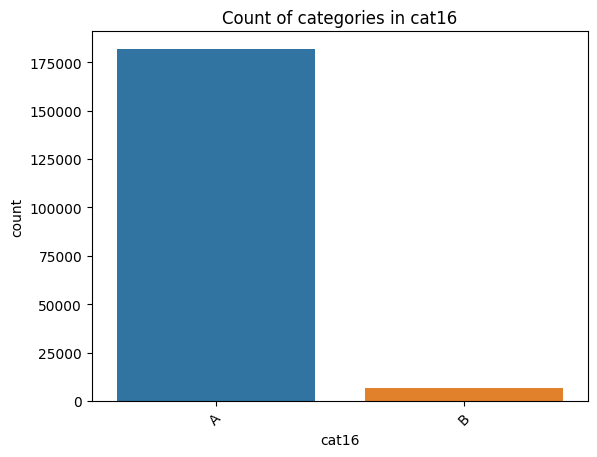

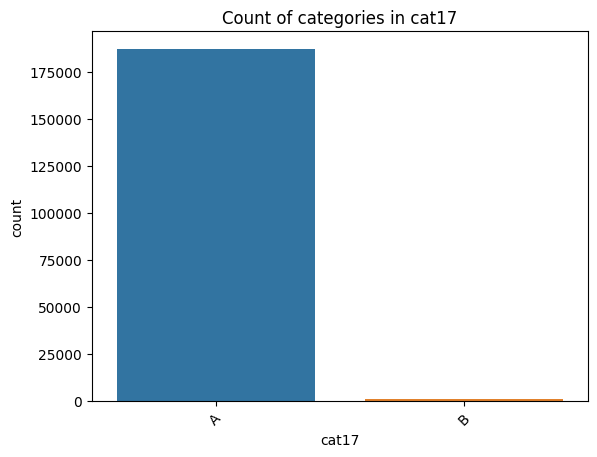

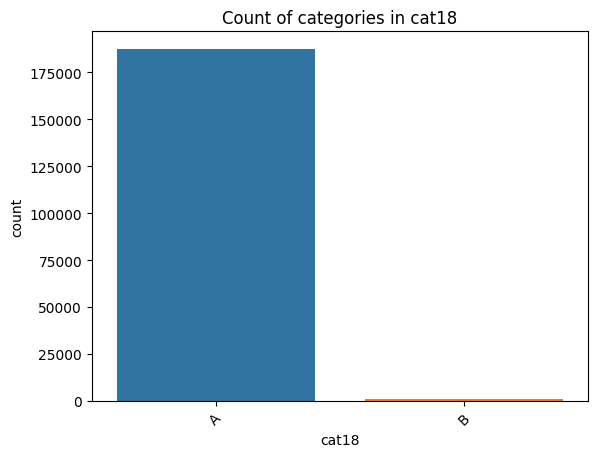

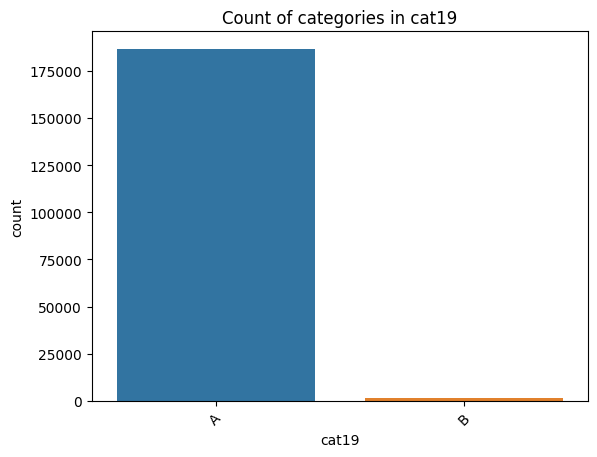

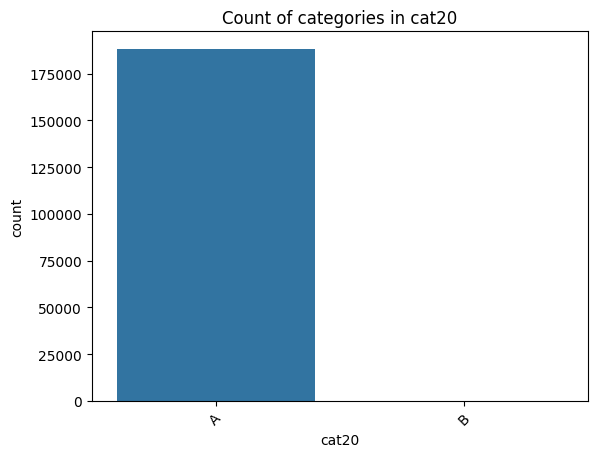

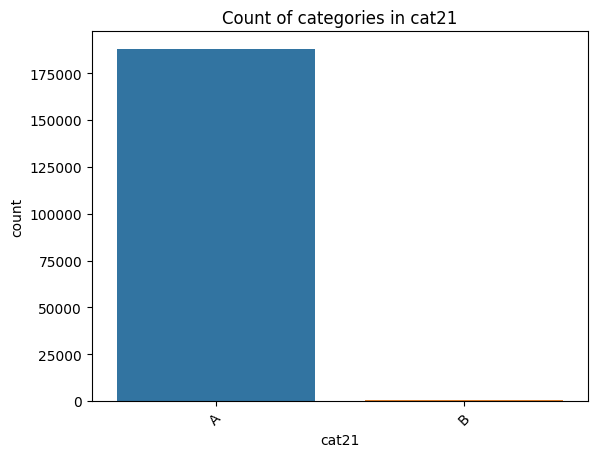

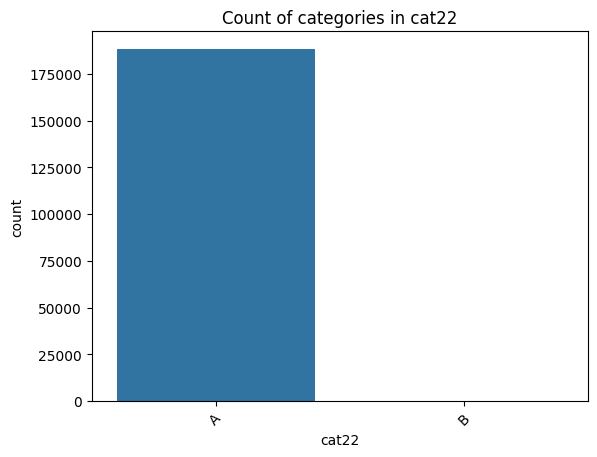

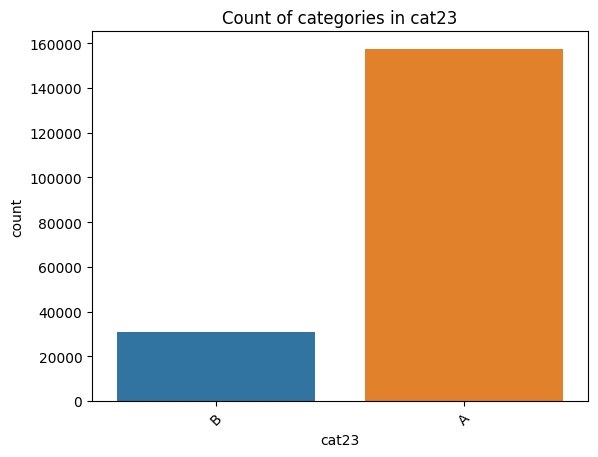

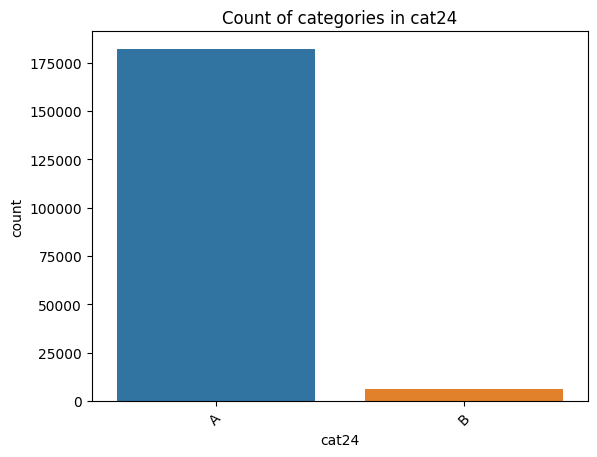

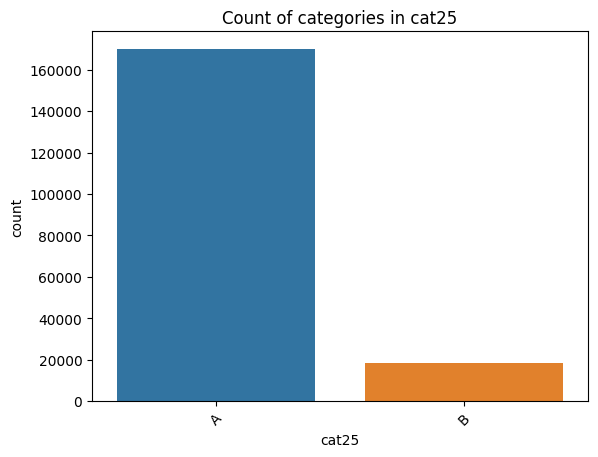

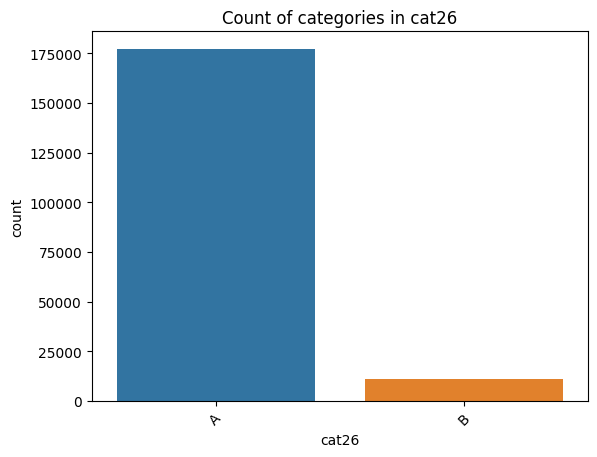

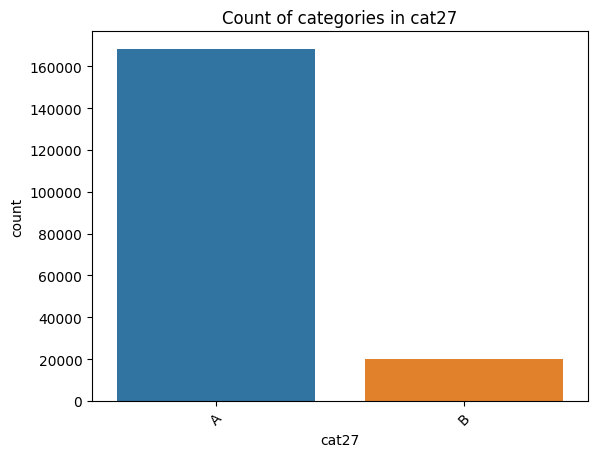

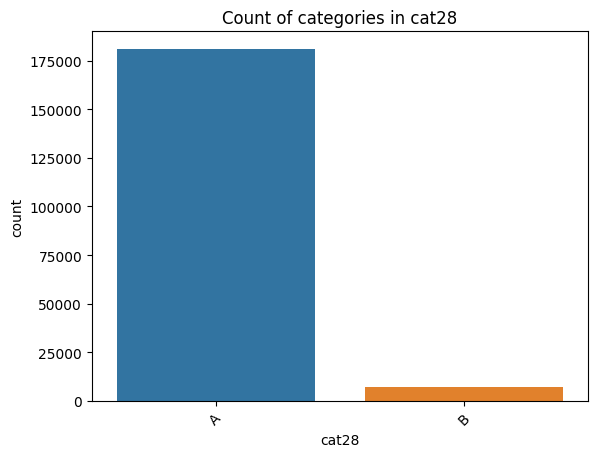

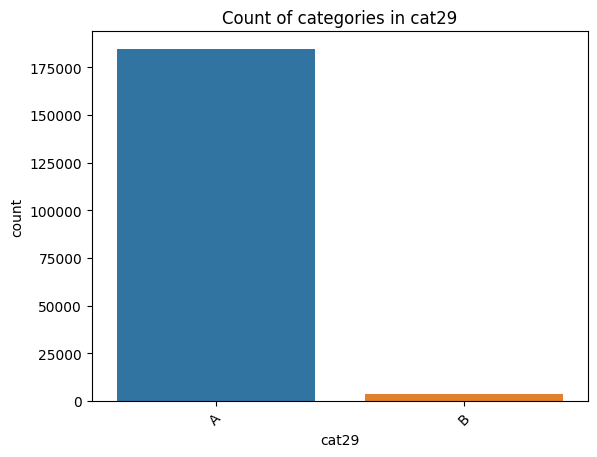

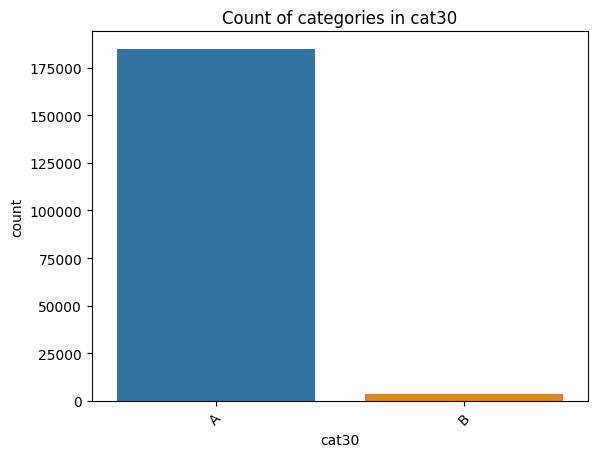

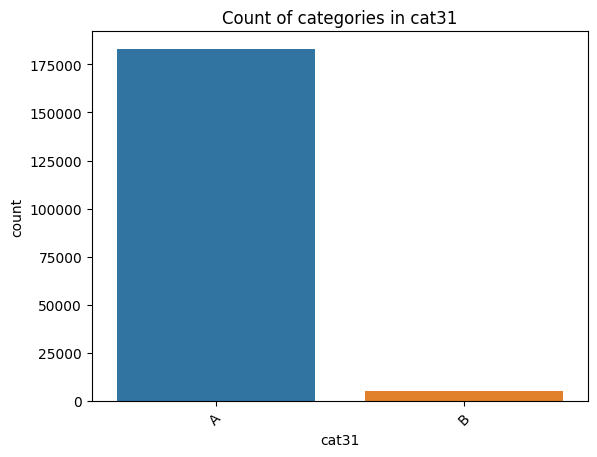

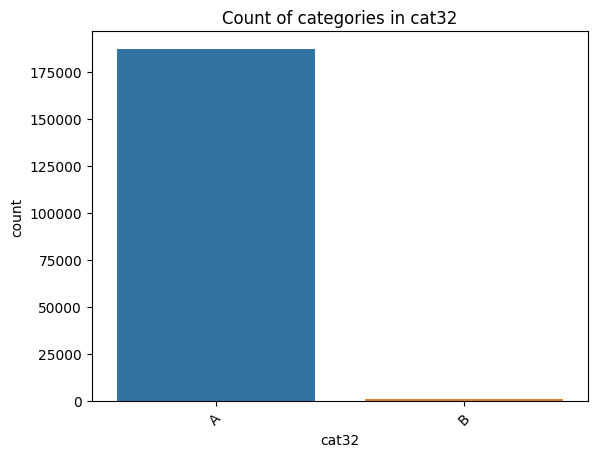

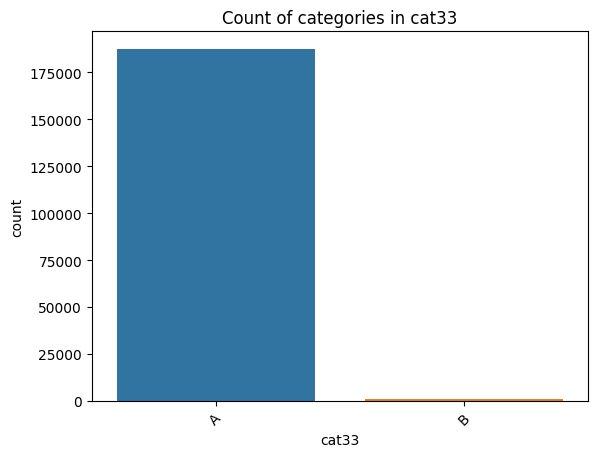

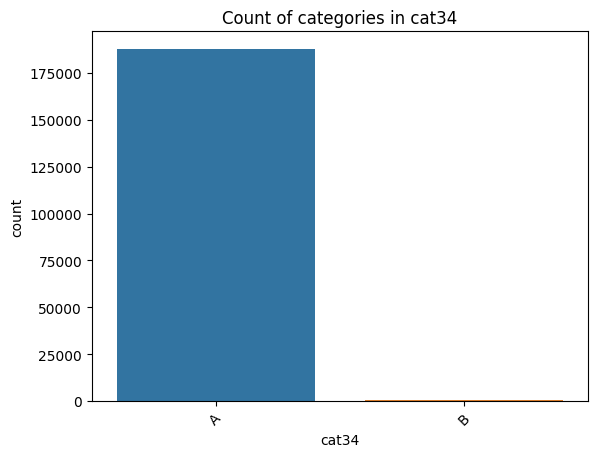

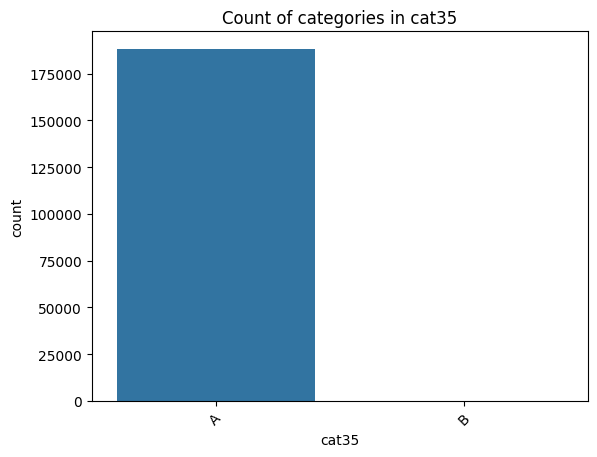

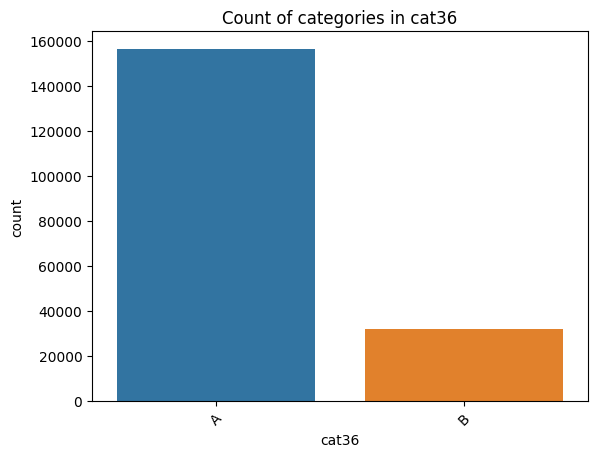

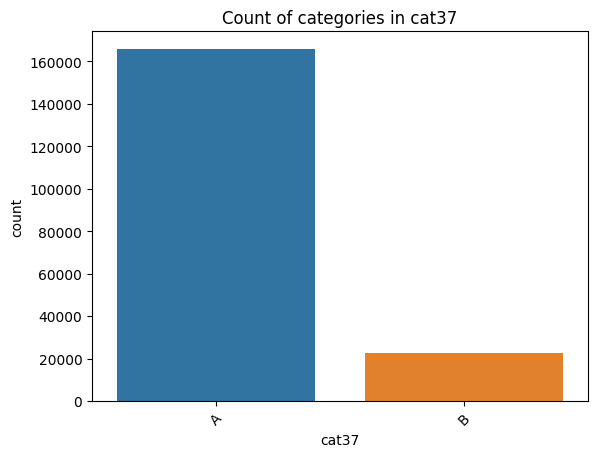

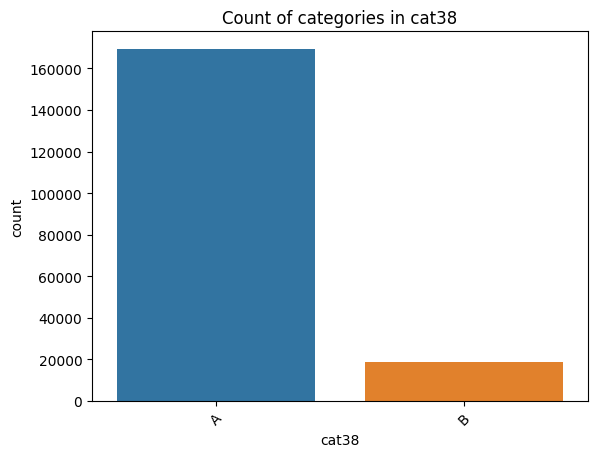

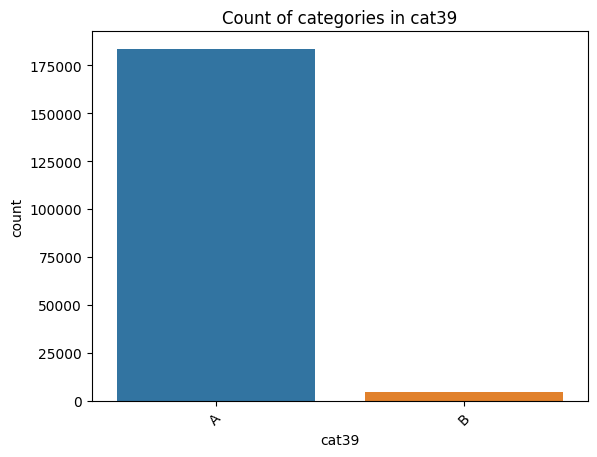

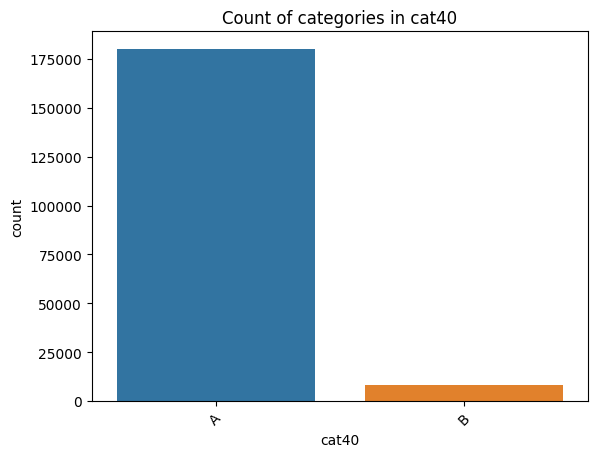

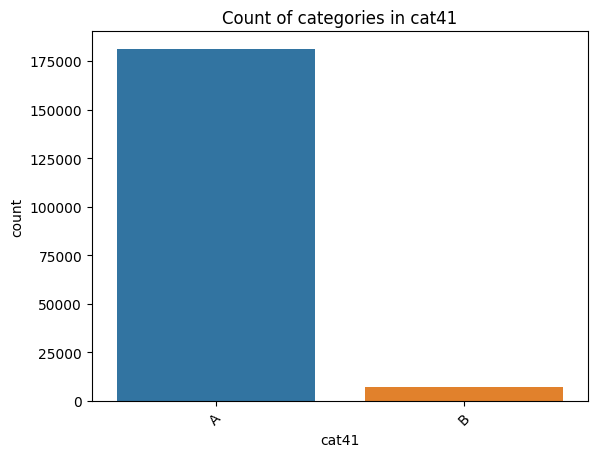

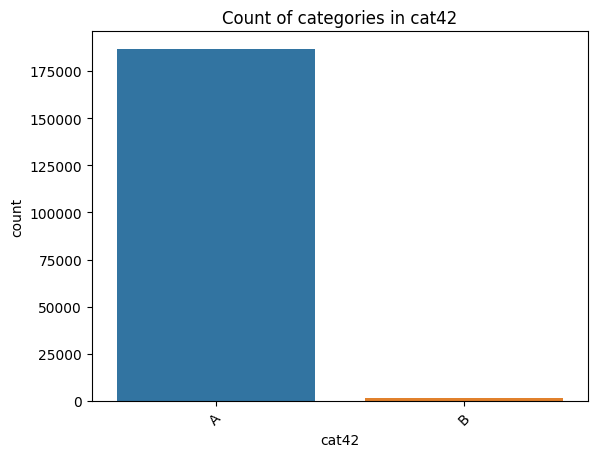

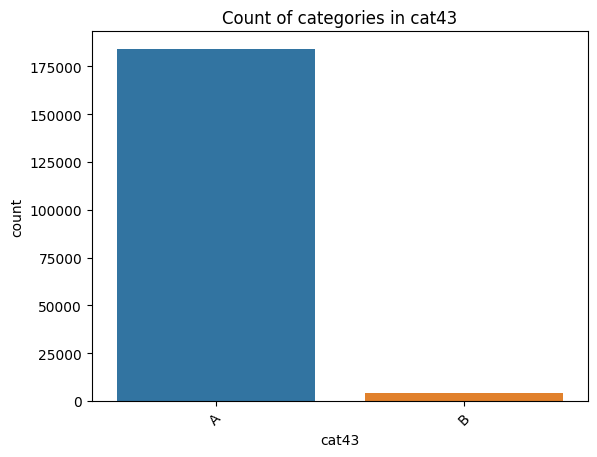

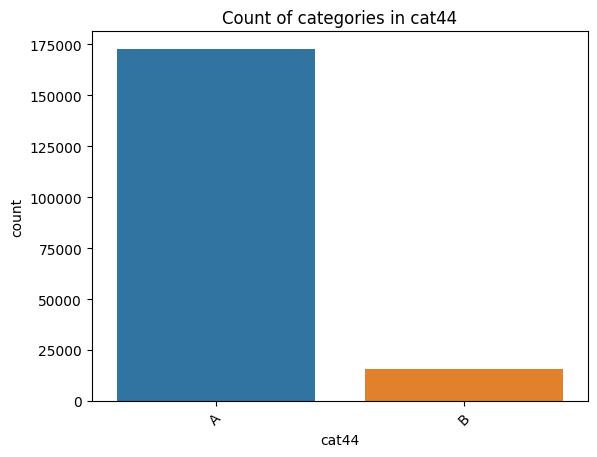

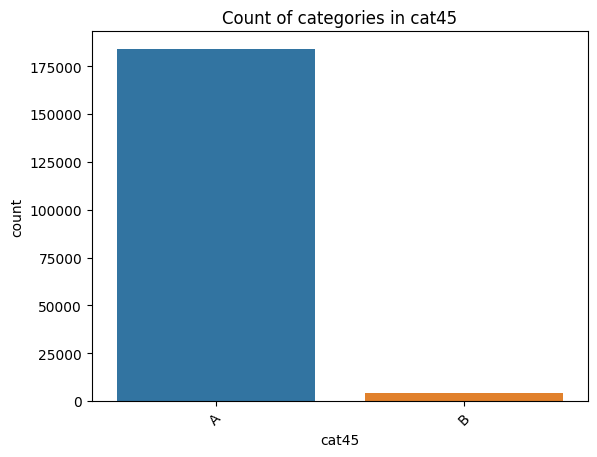

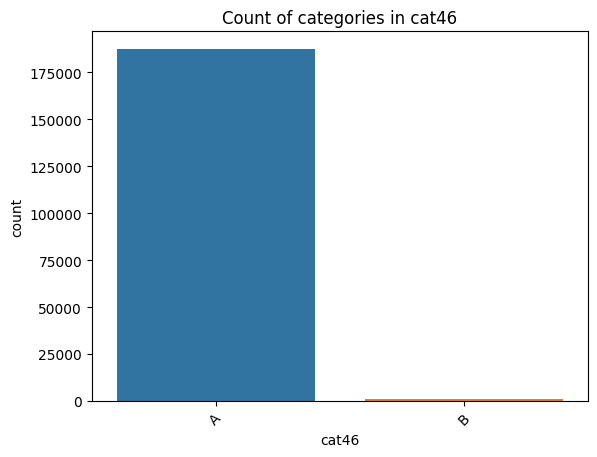

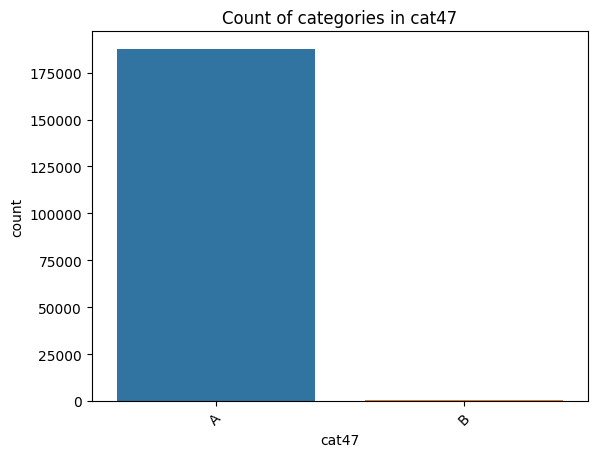

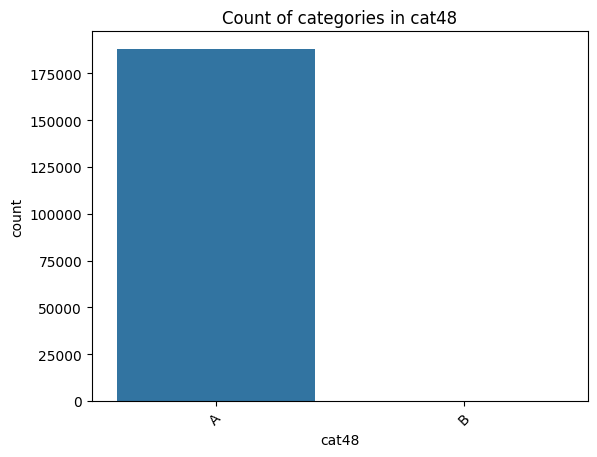

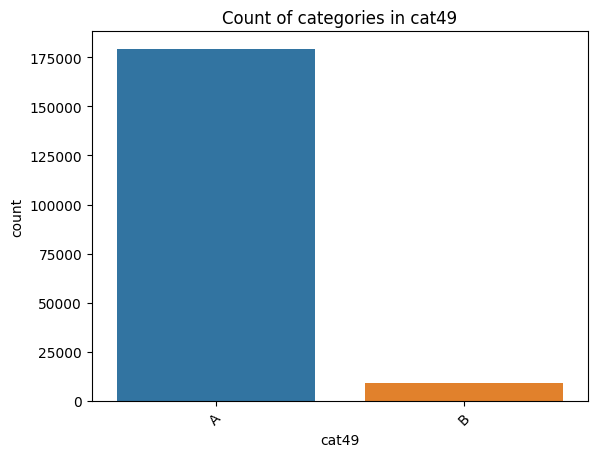

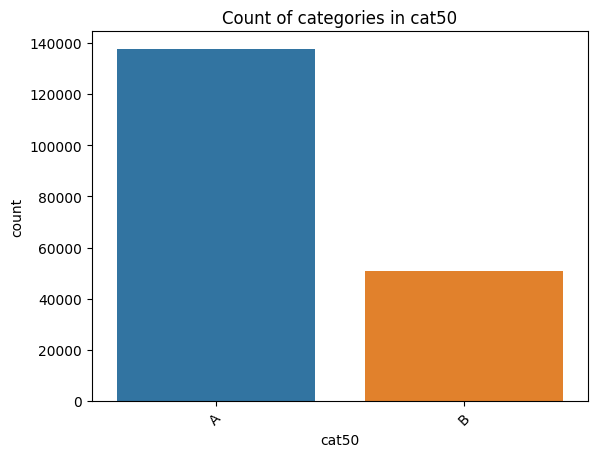

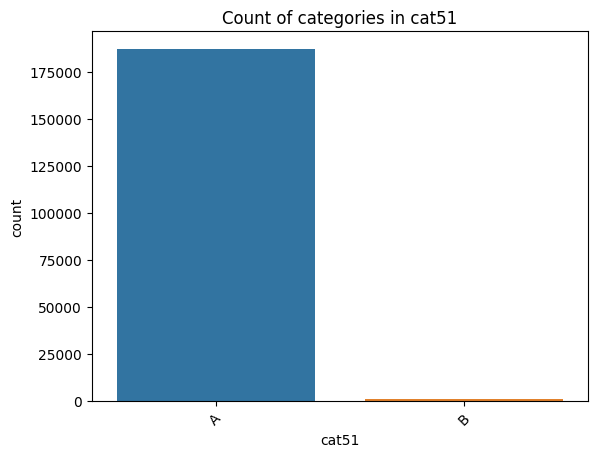

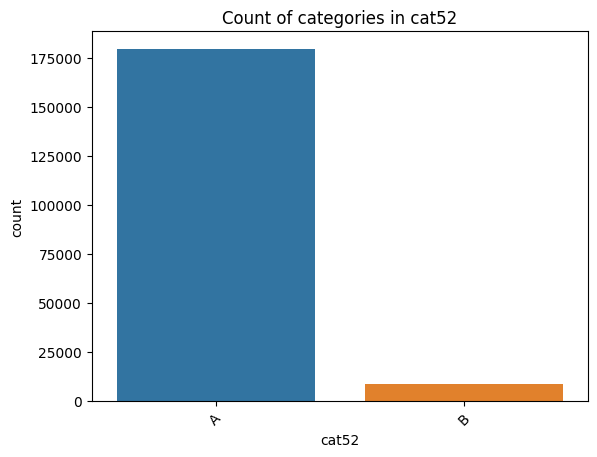

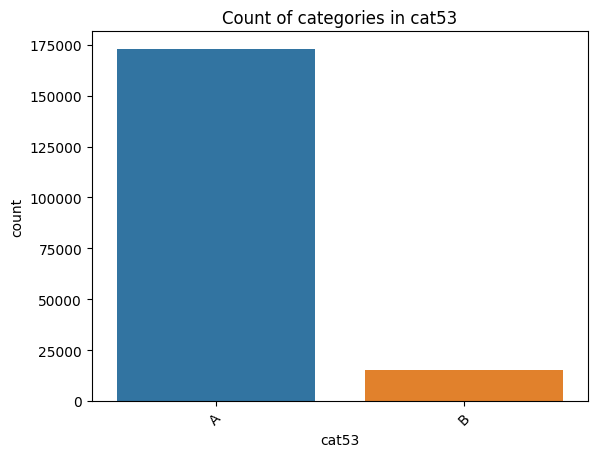

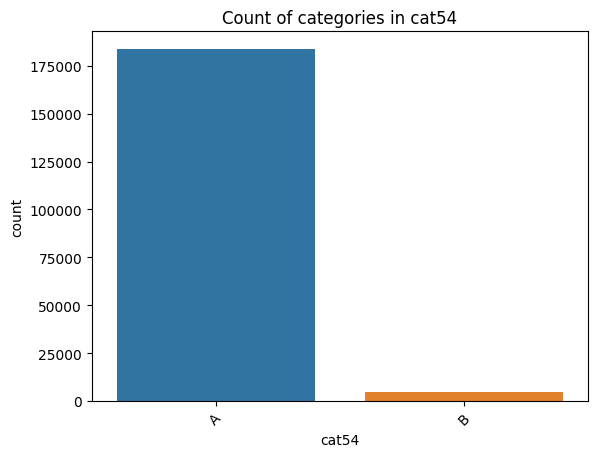

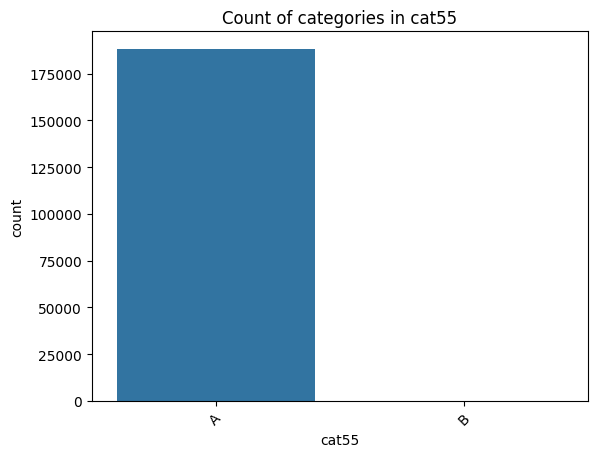

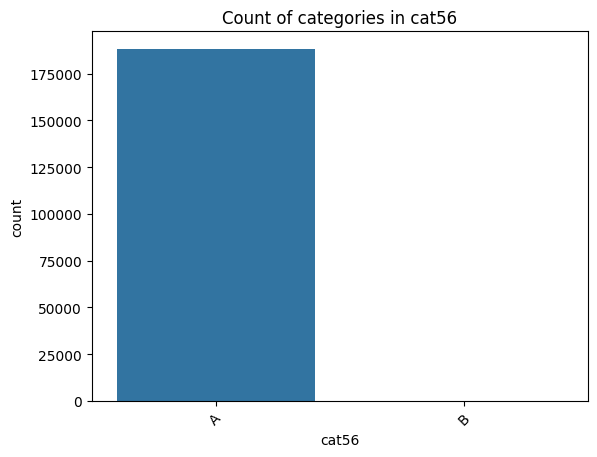

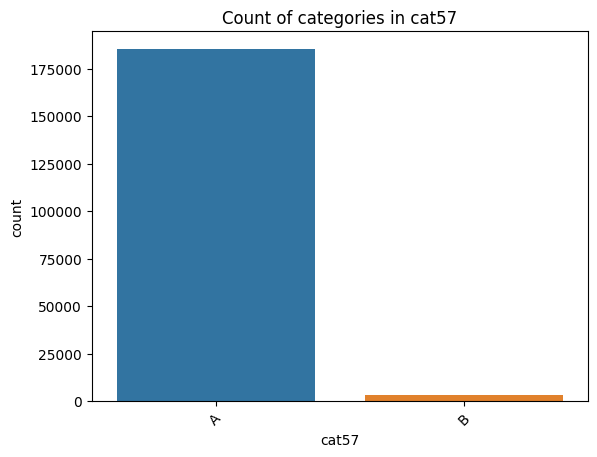

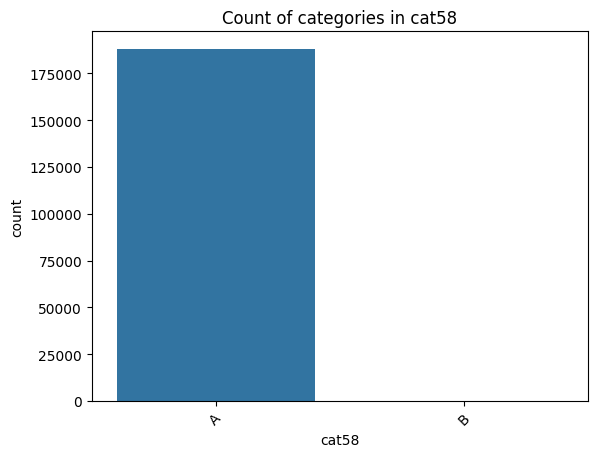

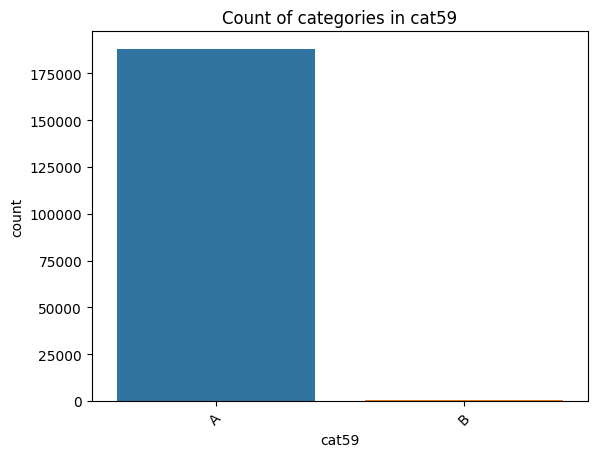

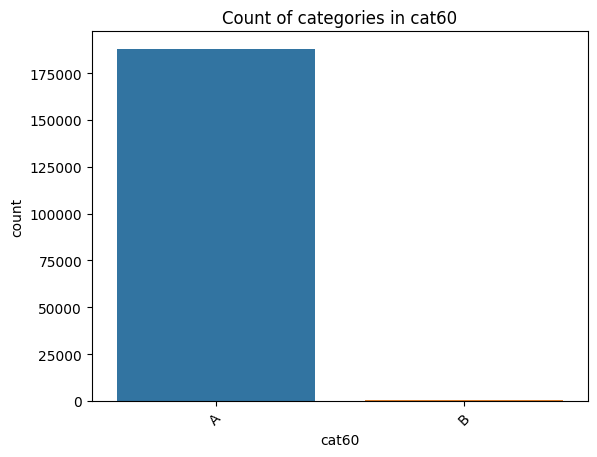

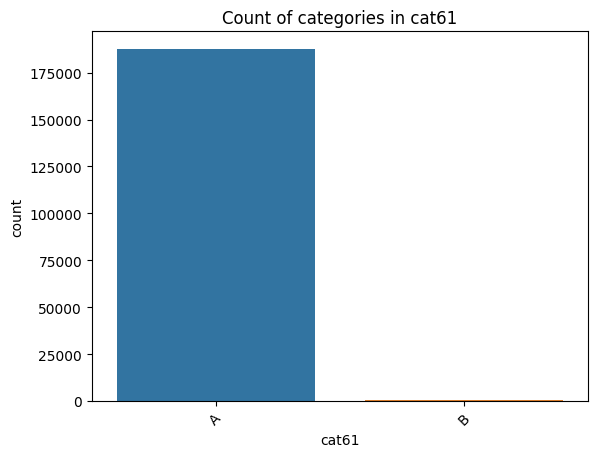

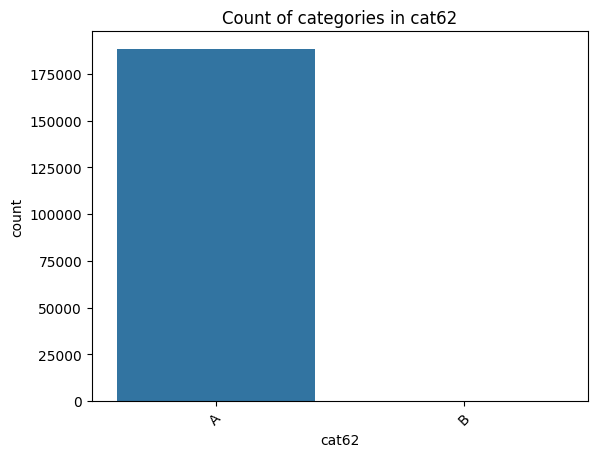

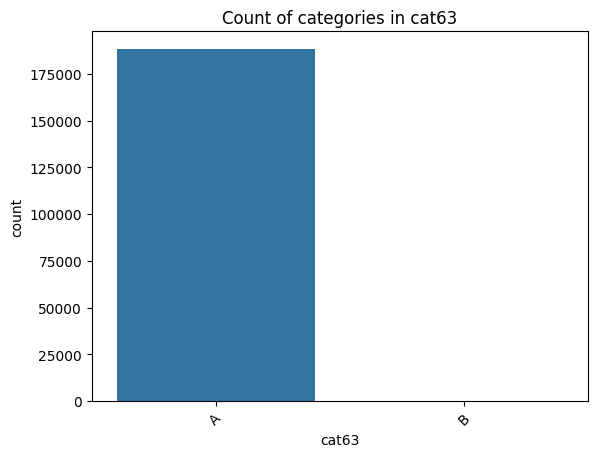

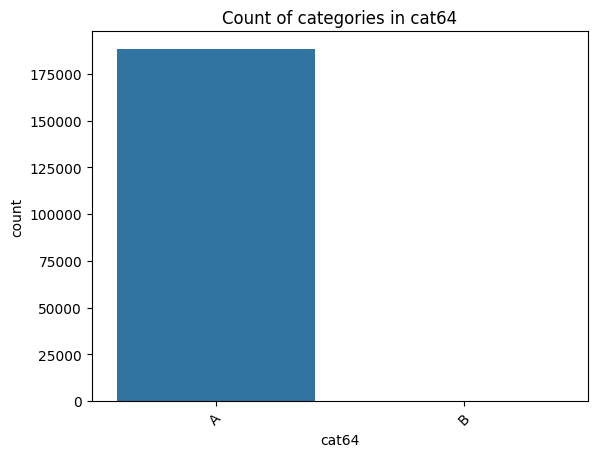

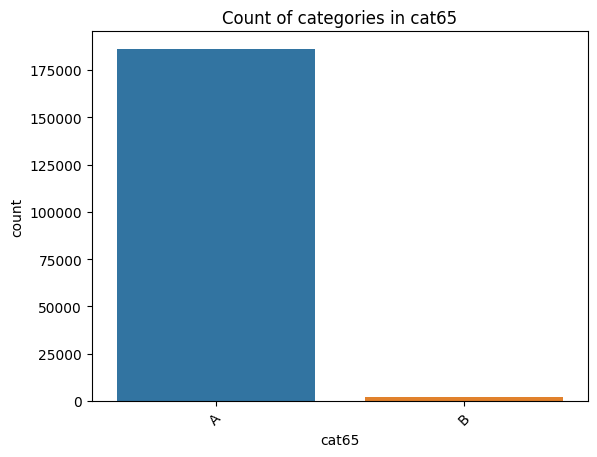

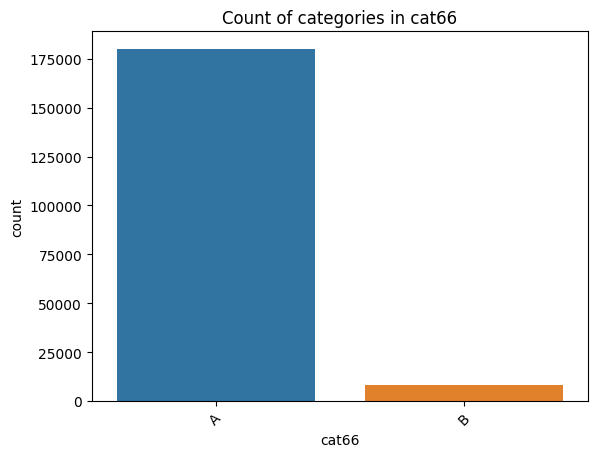

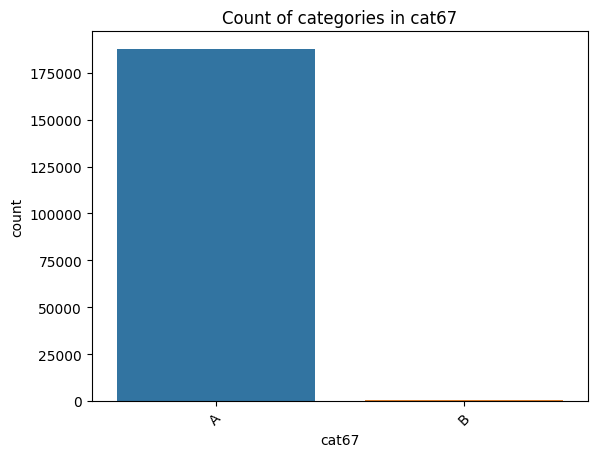

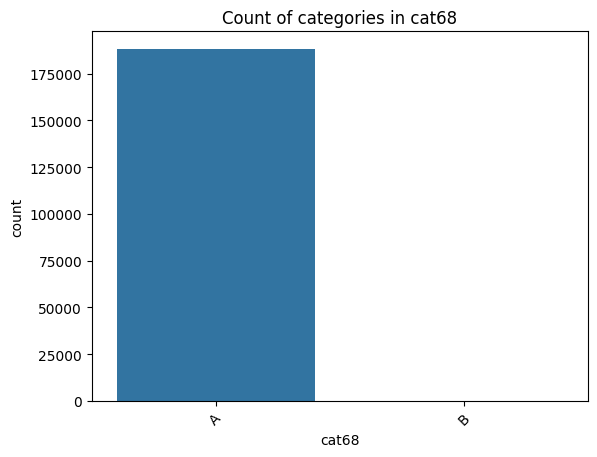

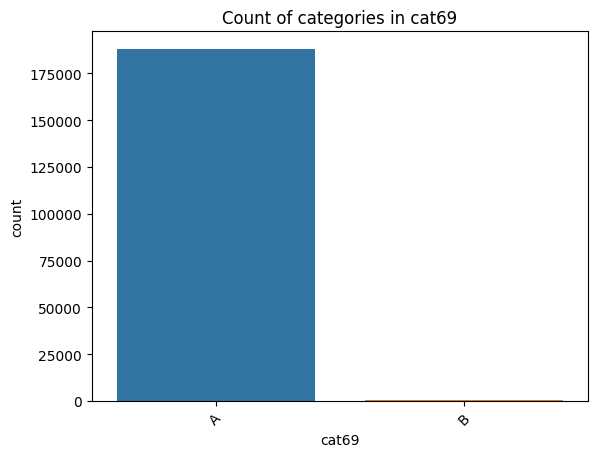

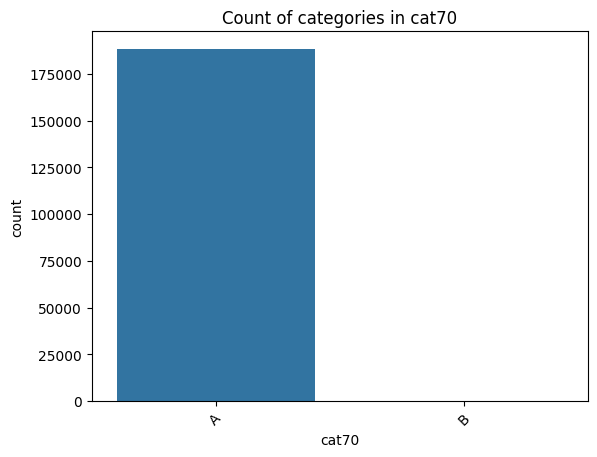

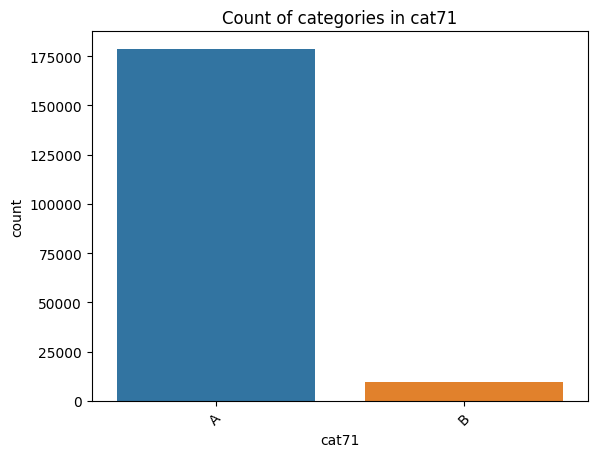

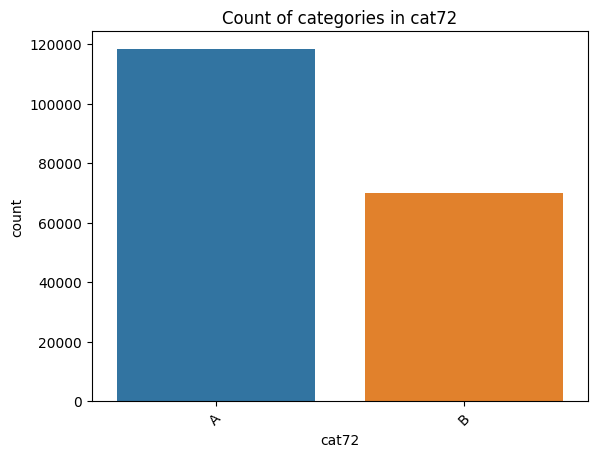

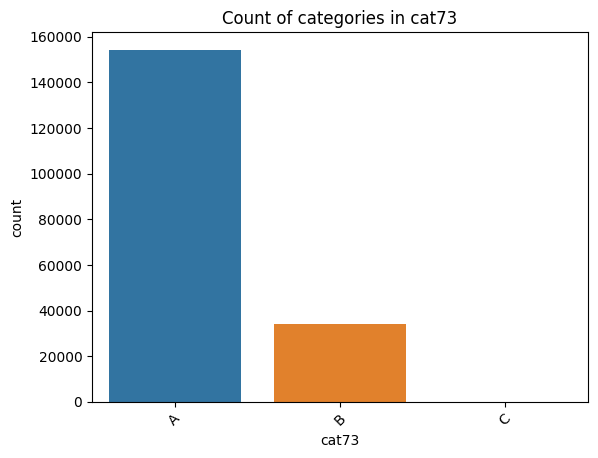

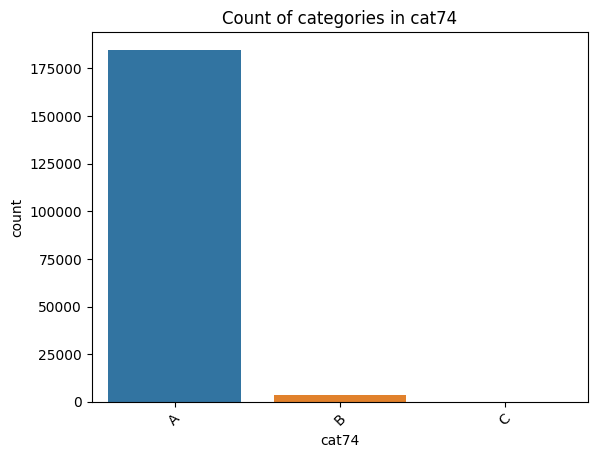

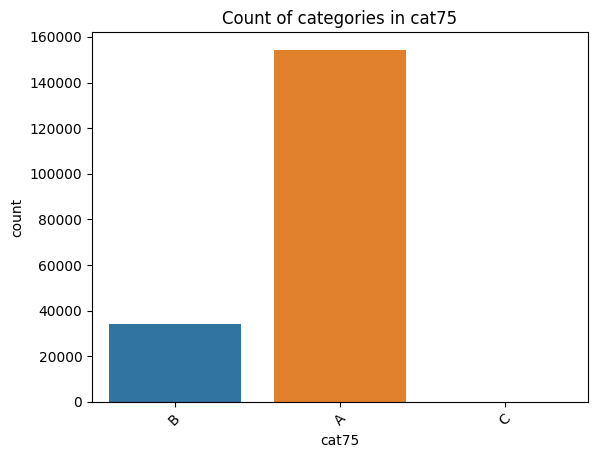

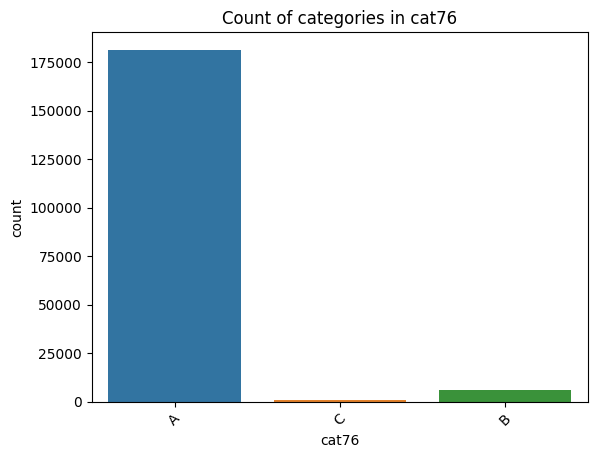

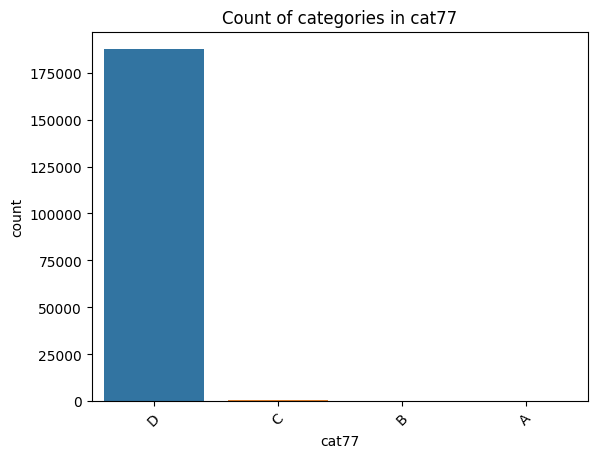

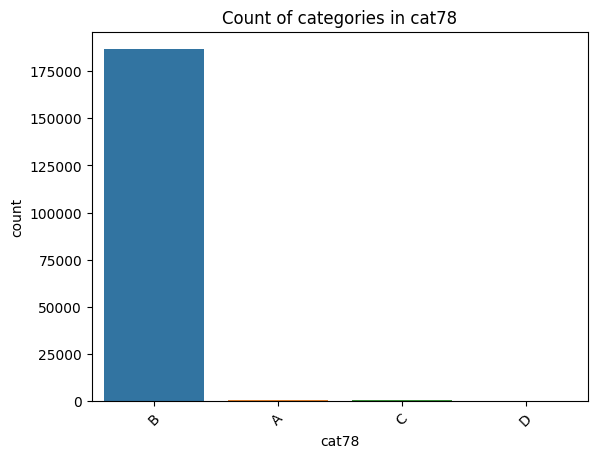

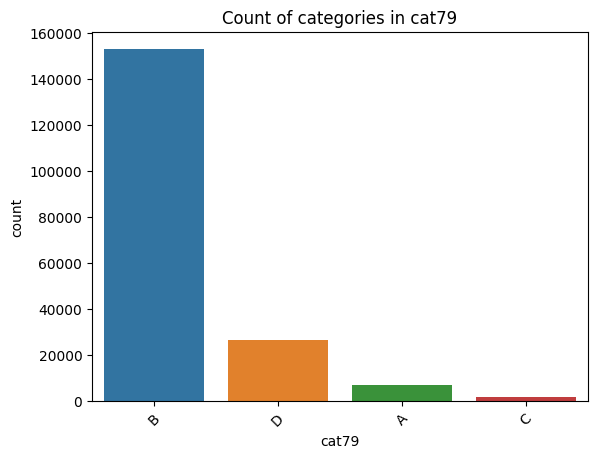

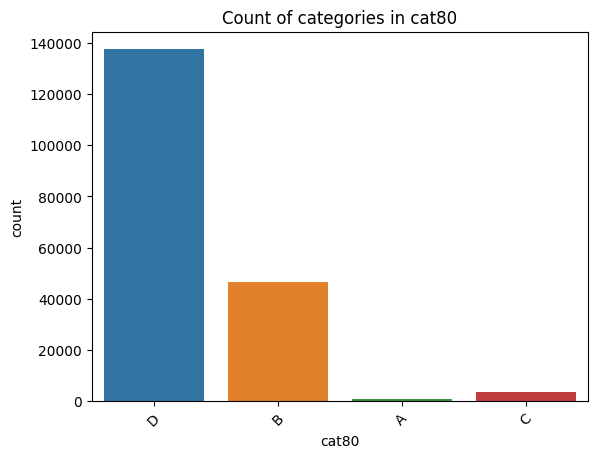

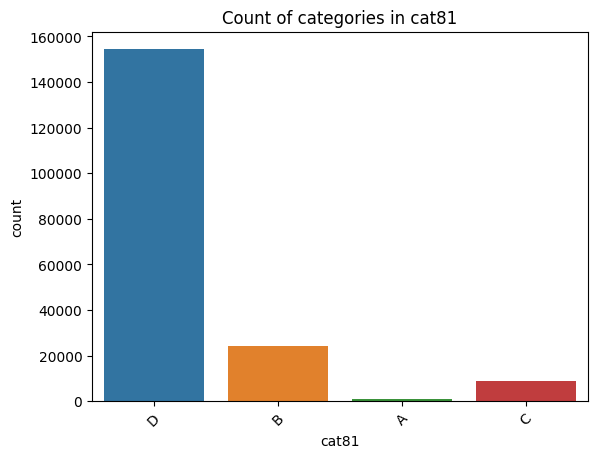

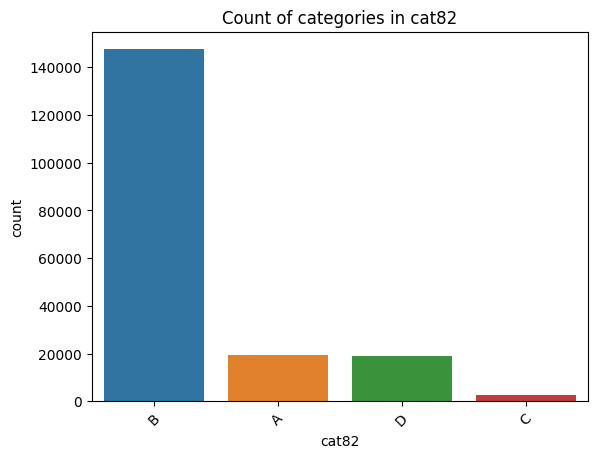

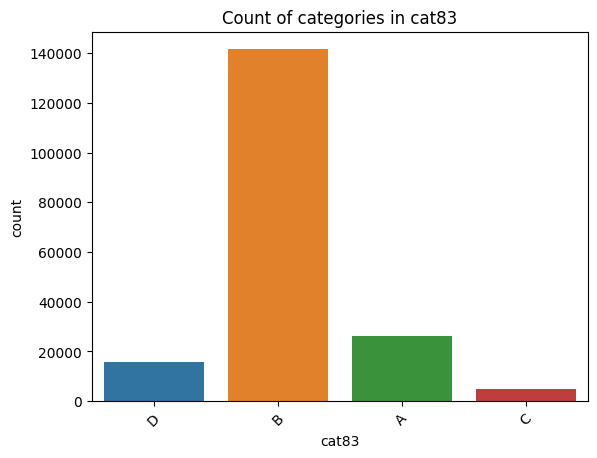

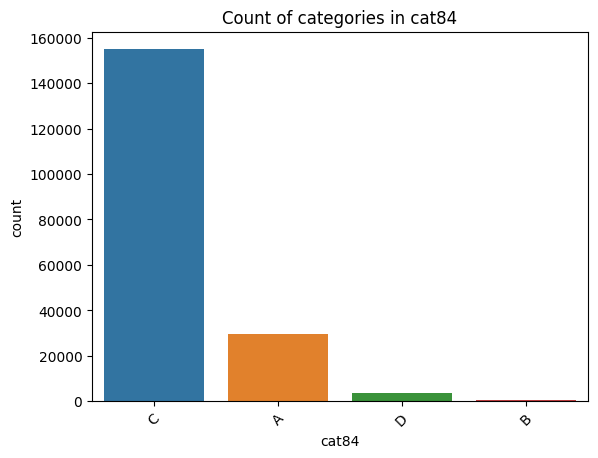

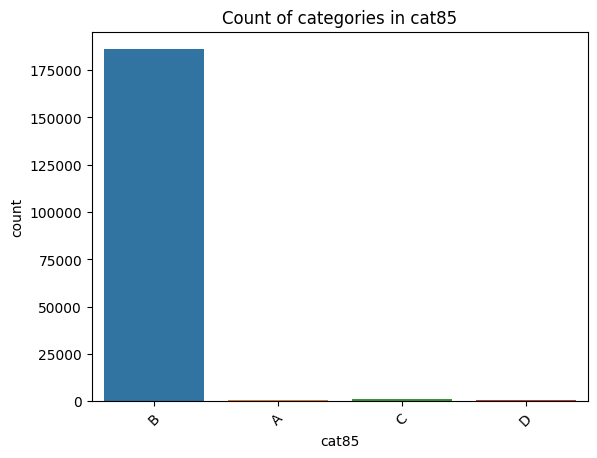

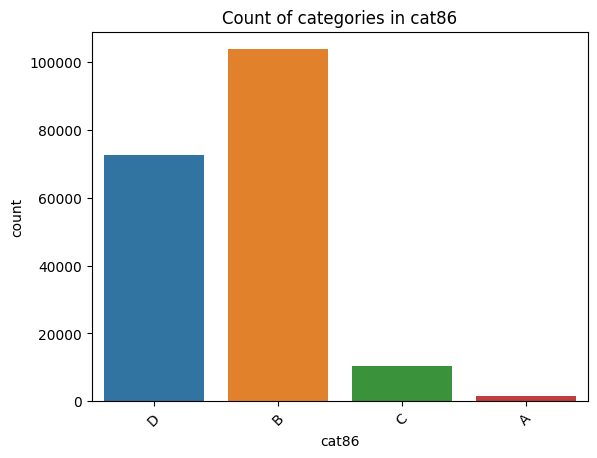

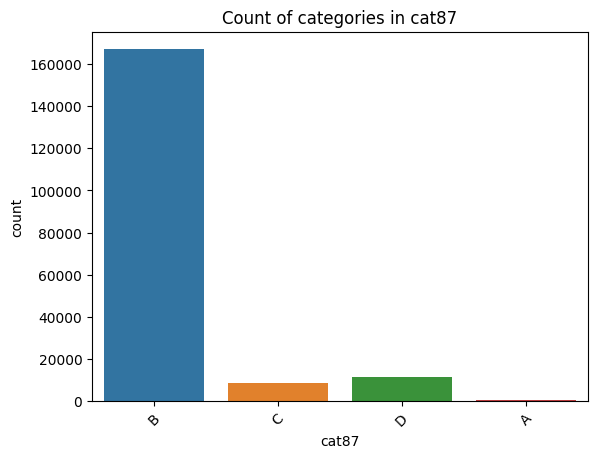

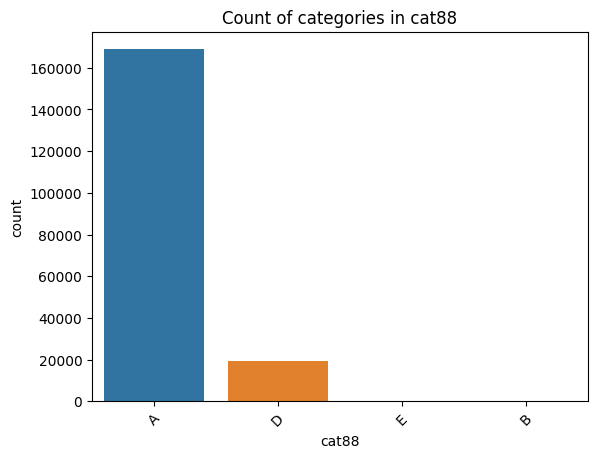

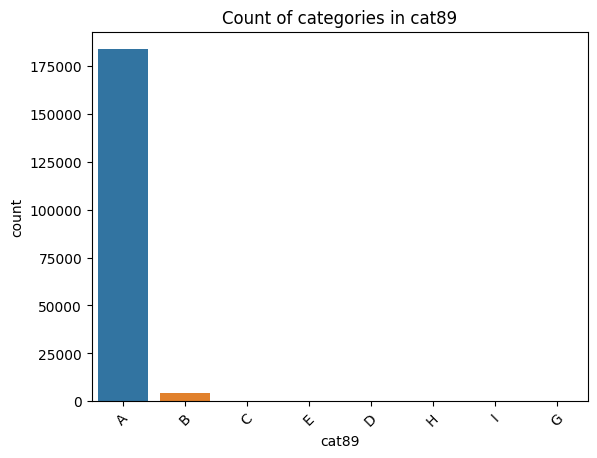

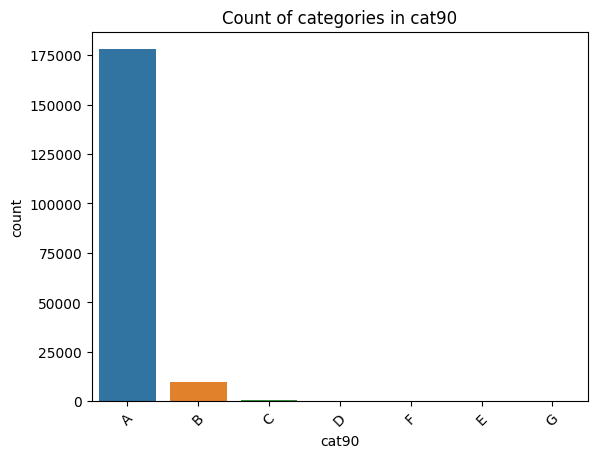

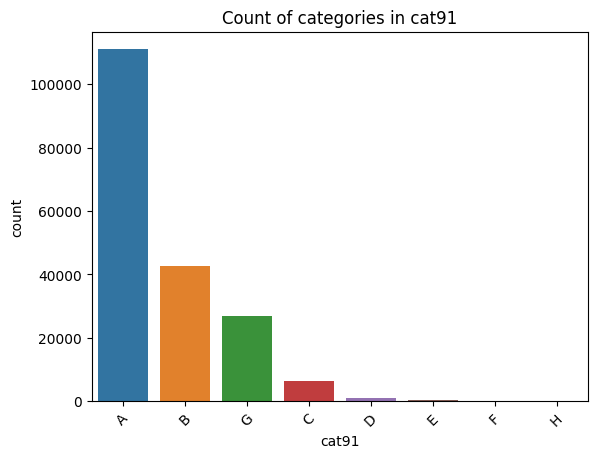

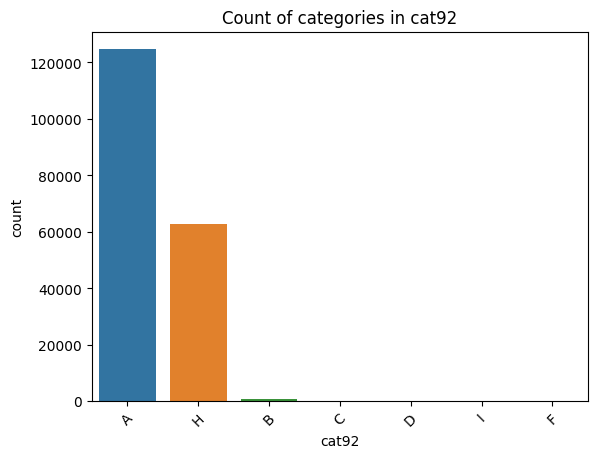

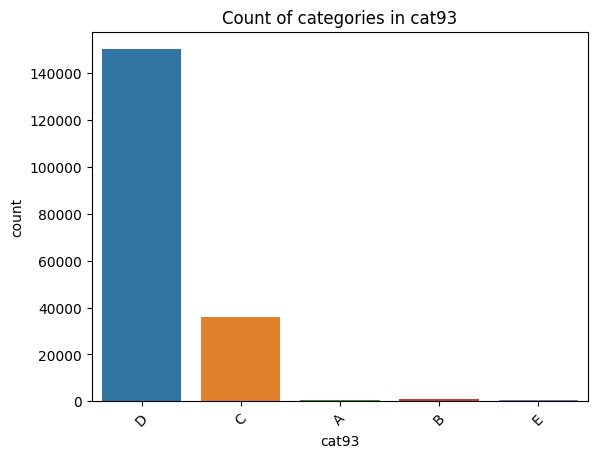

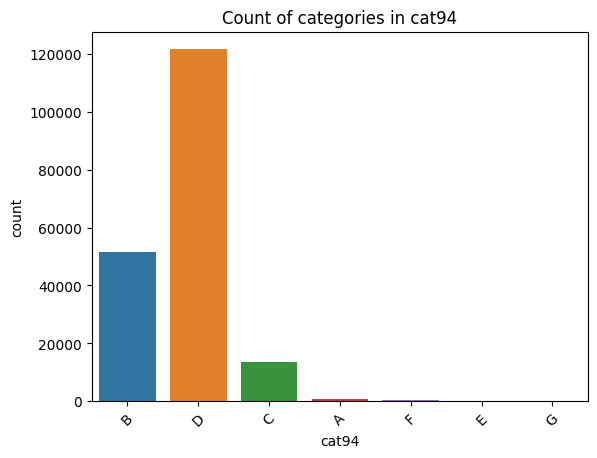

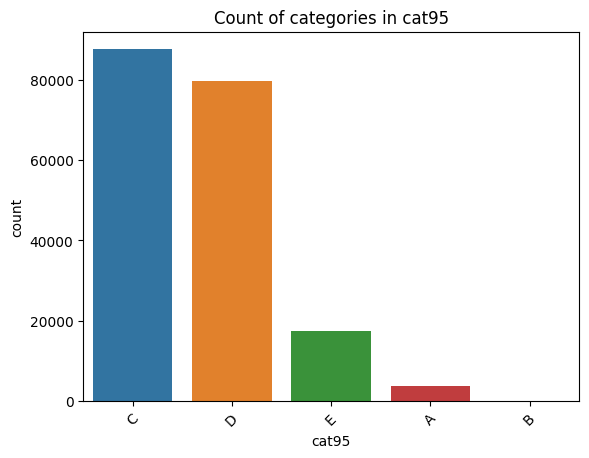

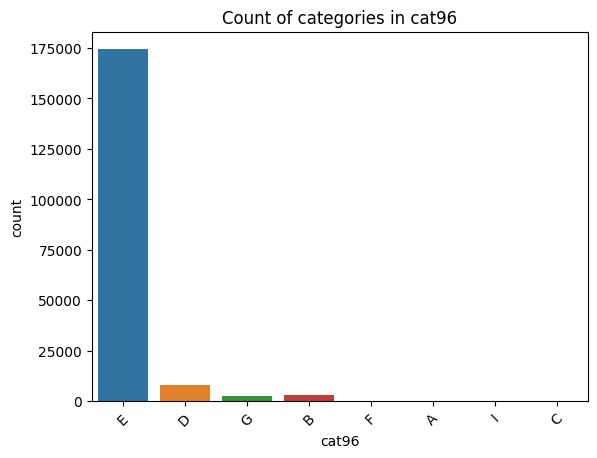

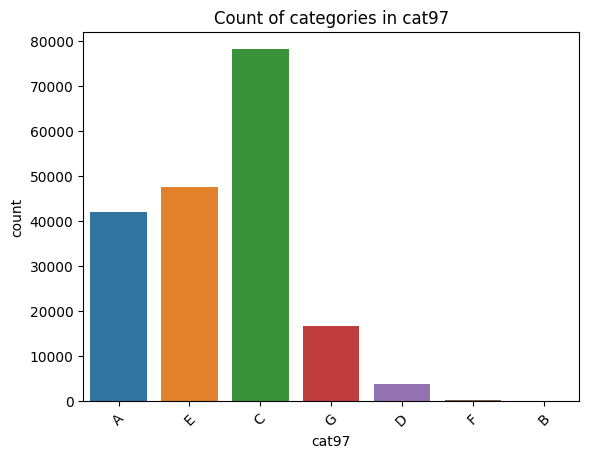

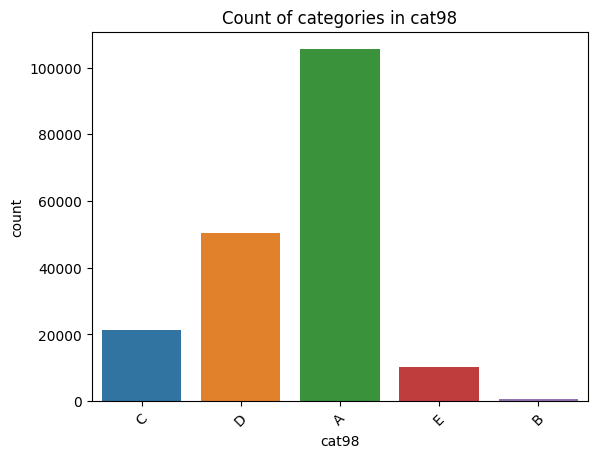

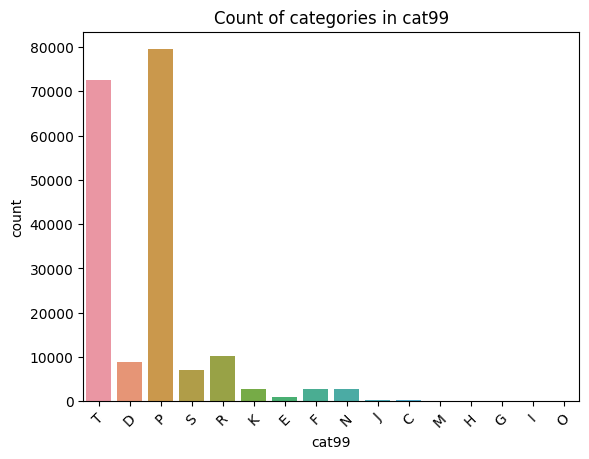

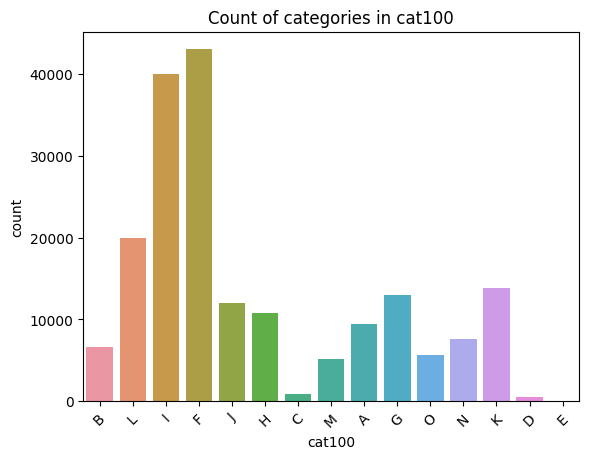

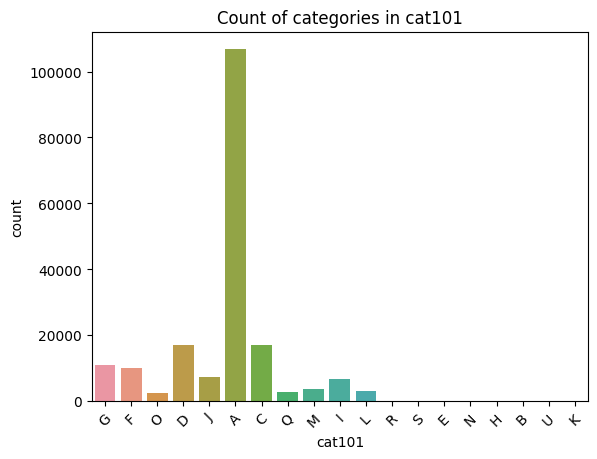

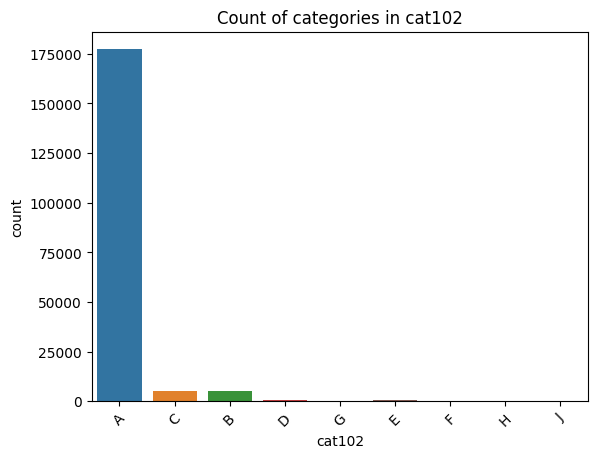

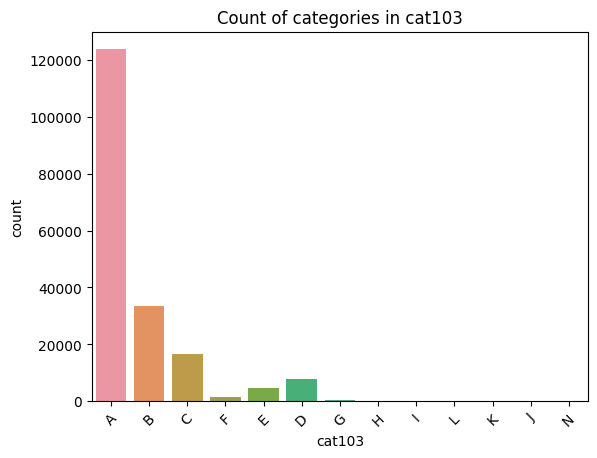

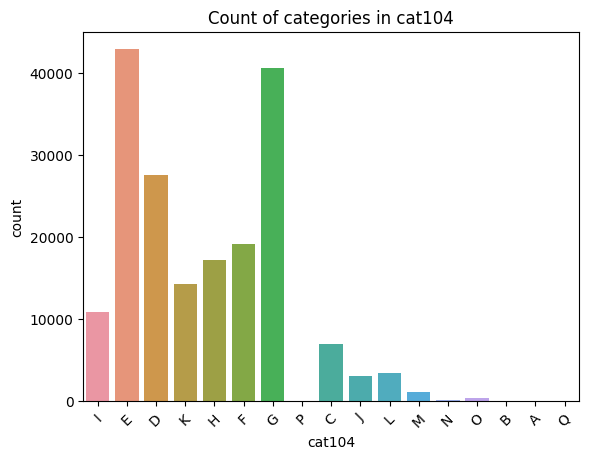

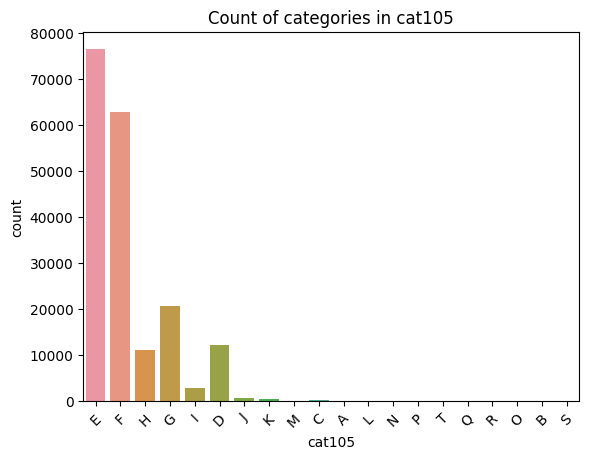

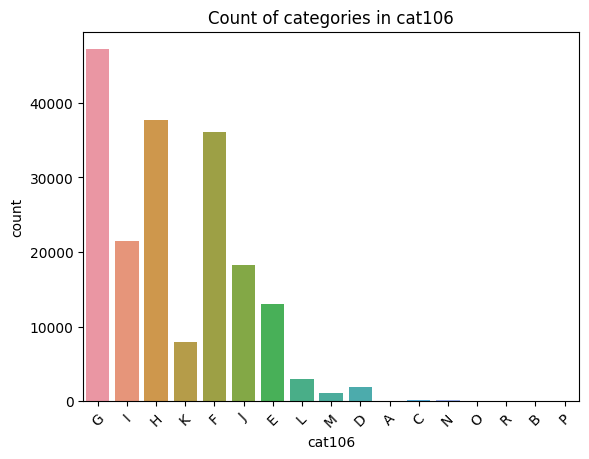

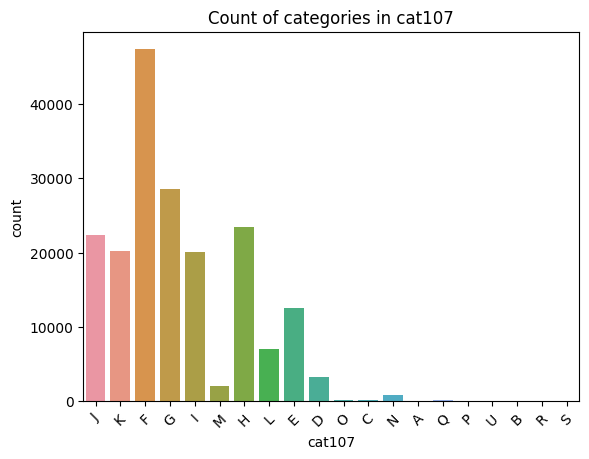

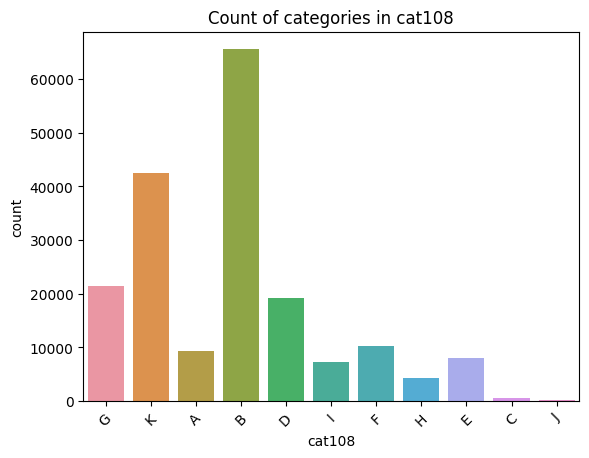

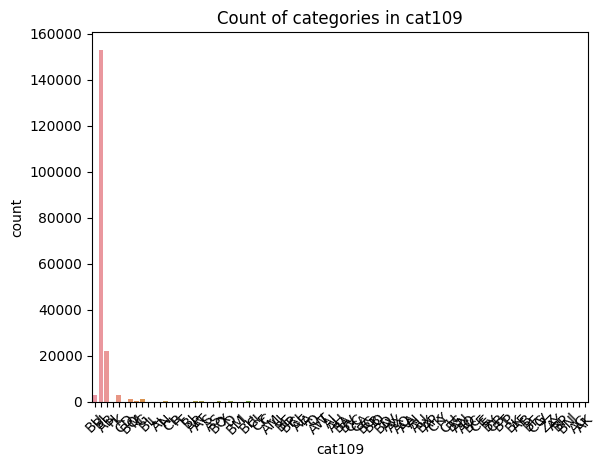

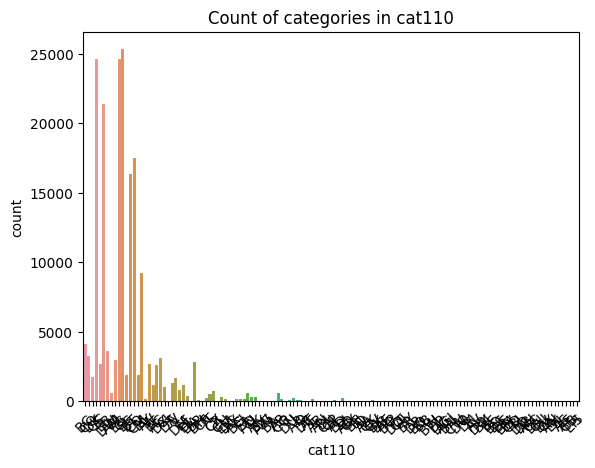

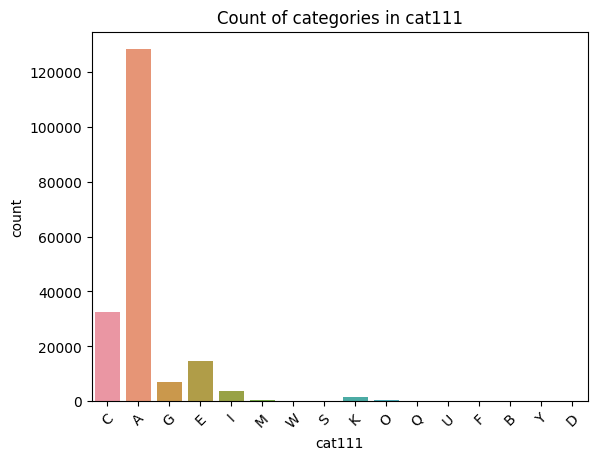

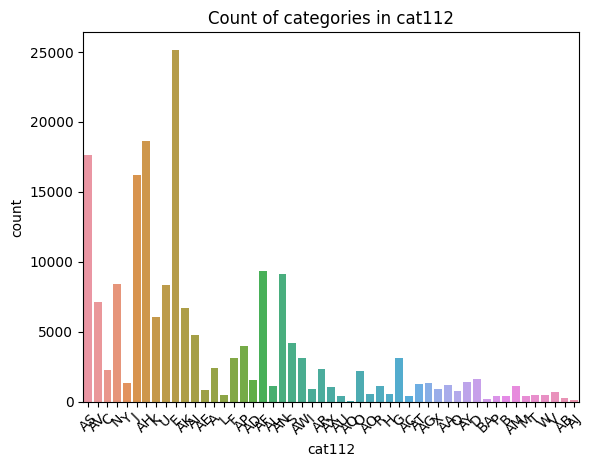

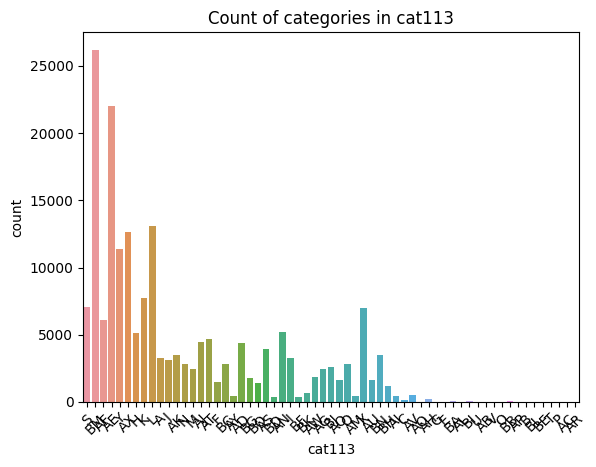

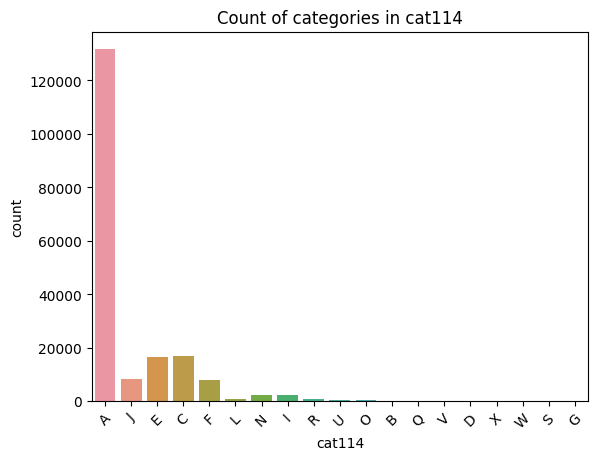

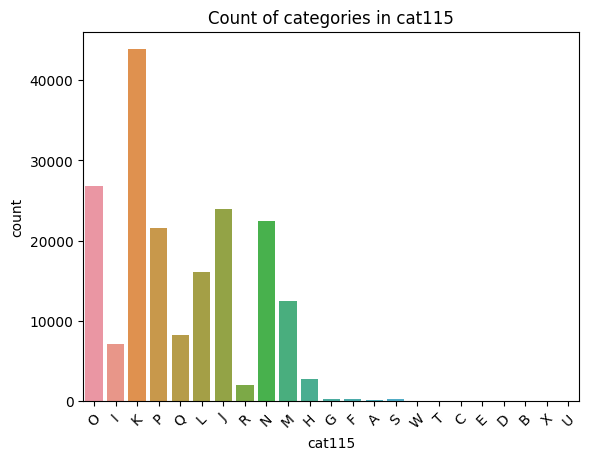

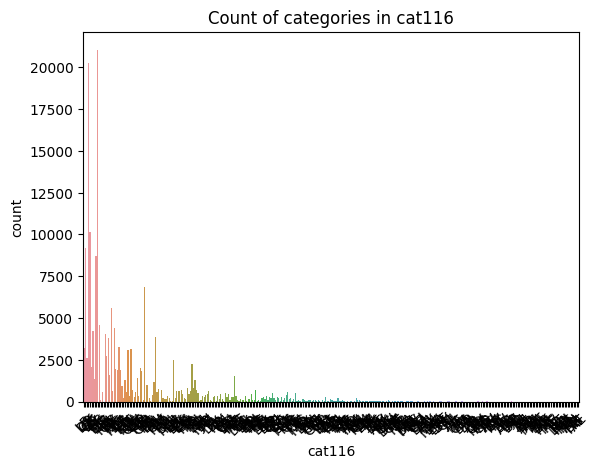

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# For numeric features
for feature in numeric_features:
    sns.histplot(train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# For categorical features (displaying the count of each category)
for feature in categorical_features:
    sns.countplot(data=train, x=feature)
    plt.title(f'Count of categories in {feature}')
    plt.xticks(rotation=45)
    plt.show()


Epoch 1/20
9416/9416 [==============================] - 24s 3ms/step - loss: 1132.7133 - val_loss: 1146.3735
Epoch 2/20
9416/9416 [==============================] - 19s 2ms/step - loss: 1130.5863 - val_loss: 1150.8048
Epoch 3/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1128.7996 - val_loss: 1145.5665
Epoch 4/20
9416/9416 [==============================] - 20s 2ms/step - loss: 1126.8004 - val_loss: 1145.6069
Epoch 5/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1124.8076 - val_loss: 1148.2720
Epoch 6/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1123.1305 - val_loss: 1148.4065
Epoch 7/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1120.8853 - val_loss: 1144.8098
Epoch 8/20
9416/9416 [==============================] - 17s 2ms/step - loss: 1119.4882 - val_loss: 1149.8101
Epoch 9/20
9416/9416 [==============================] - 18s 2ms/step - loss: 1118.1592 - val_loss: 1152.4220
Epoch 10/20
9416/94

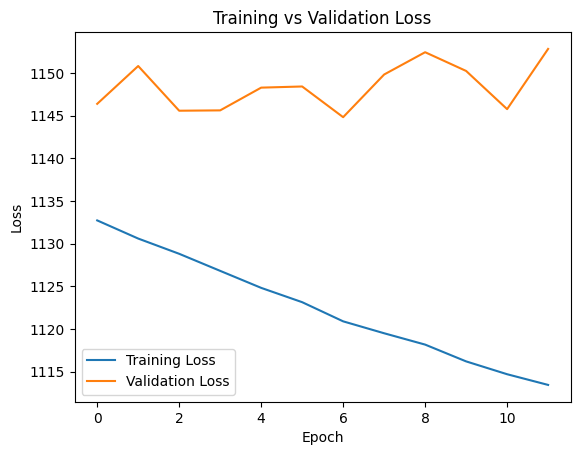

In [24]:
history = model.fit(X_train_dense, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_dense, y_val_split),
                    callbacks=[early_stop])

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


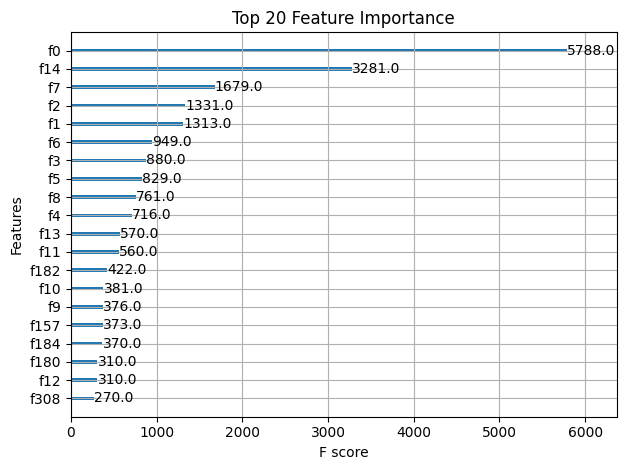

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Displaying the top 20 most important features
xgb.plot_importance(bst, max_num_features=20)
plt.title('Top 20 Feature Importance')
plt.tight_layout()  # This ensures the feature names fit within the figure boundaries
plt.show()


1177/1177 [==============================] - 2s 2ms/step


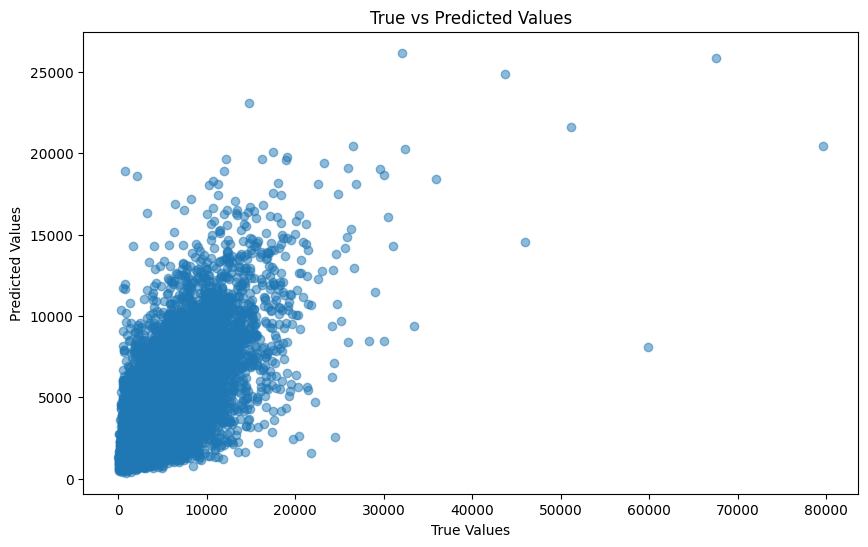

In [27]:
y_pred = model.predict(X_val_dense)

plt.figure(figsize=(10, 6))
plt.scatter(y_val_split, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


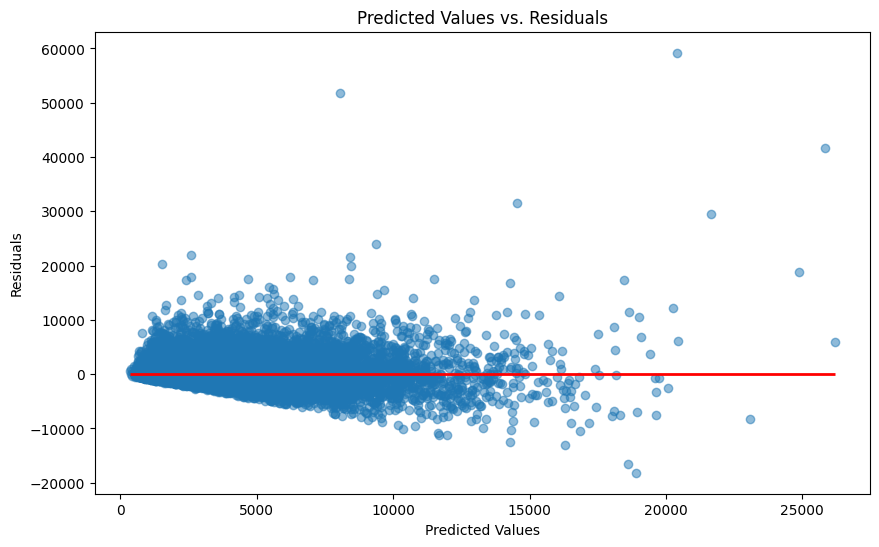

In [28]:
residuals = y_val_split - y_pred.reshape(-1)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Predicted Values vs. Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(0, min(y_pred), max(y_pred), colors='r', linewidth=2)
plt.show()


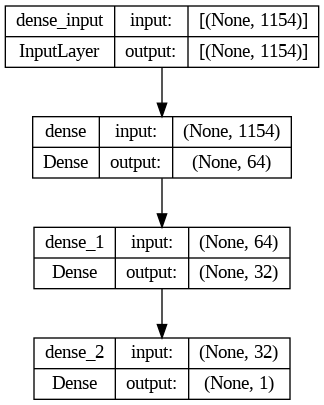

In [29]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [30]:
dtest = xgb.DMatrix(test_preprocessed)
predictions = bst.predict(dtest)


In [31]:
submission = pd.DataFrame({
    "id": test['id'],
    "loss": predictions
})


In [32]:
submission.to_csv('submission.csv', index=False)


In [33]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>